# Linear Kernel Decoder-only transformer experiments

This notebook contains experiments of Linear Kernel attention decoder-only transformer applied in the context of timeseries forecasting. In this notebook, you will find the following experiments:
- **Experiment 1**: 1-step prediction on `SimplePeriodicDataset` with overlapping source and target
- **Experiment 2**: $n$-step prediction on `SimplePeriodicDataset` with overlapping source and target
- **Experiment 3**: $n$-step prediction on `SimplePeriodicDataset` with non-overlapping source and target
- **Experiment 4**: $n$-step prediction on `MultivarPeriodicDataset` with non-overlapping source and target and $m$ time series
- **Experiment 5**: $n$-step prediction on `(Decaying/Multi)StepSyntheticDataset` with non-overlapping source and target
- **Experiment 6**: $n$-step prediction on `(Decaying/Multi)SineSyntheticDataset` with non-overlapping source and target
- **Experiment 7**: $n$-step prediction on `(Decaying/Multi)SawtoothSyntheticDataset` with non-overlapping source and target

For visualization and inspection purposes, we use 3 decoder layers and a single attention head

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

import src.Datasets.SyntheticDataset as SD
from src.Transformer.DecoderOnly import PointDecoderOnlyTransformer
from src.Transformer.KernelAttention import LinearKernelAttention
from src.train import train_step_dec_only, val_step_dec_only
from src.utils import collate_fn, EarlyStopping

ES = EarlyStopping(patience=30, delta=0)

In [2]:
# configs
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# attention module
_attention = LinearKernelAttention()

# meta data to store images
FOLDER = "linear_kernel"
KERNEL_NAME = "linear"

# transformer configs
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
emb_size = 64                           # size of transformer block embedding (d_model)
n_hidden = emb_size // n_heads          # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = emb_size * 4             # point-wise feed forward net hidden dimensions

# train configs
ps = [0.5, 0.9]                         # rho_quantile loss probs
lr = 0.0005                             # initial learning rate
lr_step_size = 10                       # every n steps decrease learning rate by gamma
lr_gamma = 0.95                         # learning rate decrease rate
EPOCHS = 300                            # training epochs

## Experiment 1: one-step prediction on `SimplePeriodicDataset` with overlapping source and target

In [3]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 1                               # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

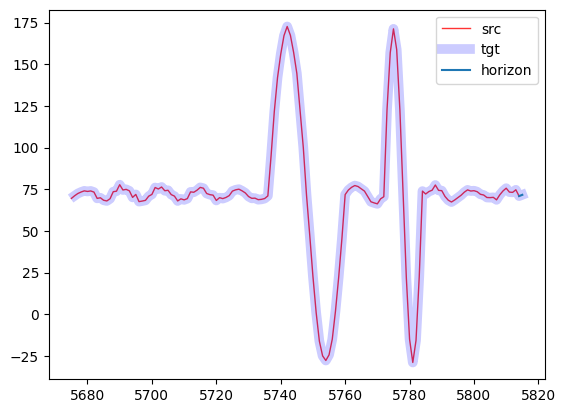

In [4]:
src_X, src_fX, tgt_X, tgt_fX = train_set[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [5]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [6]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2073.3660	val_loss=1501.5277	train_mape_loss=2.7078	val_mape_loss=2.8466	R_p=['0.2791', '0.2575']
epoch=1	train_loss=1521.3182	val_loss=1501.3725	train_mape_loss=2.9881	val_mape_loss=2.8643	R_p=['0.2789', '0.2531']
epoch=2	train_loss=1519.0061	val_loss=1495.4705	train_mape_loss=2.9973	val_mape_loss=2.7836	R_p=['0.2726', '0.2685']
epoch=3	train_loss=1518.3468	val_loss=1497.7380	train_mape_loss=2.9891	val_mape_loss=2.8343	R_p=['0.2754', '0.2574']
epoch=4	train_loss=1515.8893	val_loss=1496.7970	train_mape_loss=2.9816	val_mape_loss=2.9088	R_p=['0.2878', '0.2478']
epoch=5	train_loss=1511.1088	val_loss=1490.2569	train_mape_loss=2.9789	val_mape_loss=2.8436	R_p=['0.2773', '0.2543']
epoch=6	train_loss=1562.3355	val_loss=1490.9957	train_mape_loss=2.9672	val_mape_loss=2.8158	R_p=['0.2751', '0.2613']
epoch=7	train_loss=1500.5476	val_loss=1416.3727	train_mape_loss=2.9685	val_mape_loss=2.7238	R_p=['0.2774', '0.2551']
epoch=8	train_loss=1081.2581	val_loss=322.0562	train_mape_loss=2

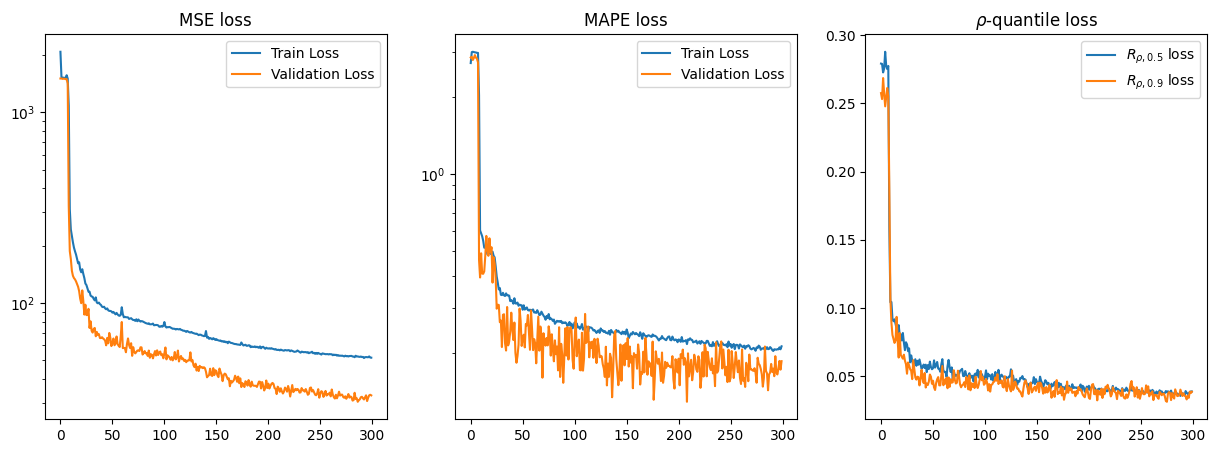

In [7]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [8]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(32.81768740844726,
 0.19680913412570952,
 [0.038935285061597824, 0.038935791701078415])

In [9]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_1pred_at_once.pth"
torch.save(best_model.state_dict(), path)

In [10]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, 0, device)

best_test_loss, best_test_mape_loss, best_r_ps

(30.2871229095459,
 0.14951583272218705,
 tensor([0.0363, 0.0362], device='cuda:0'))

### Predict

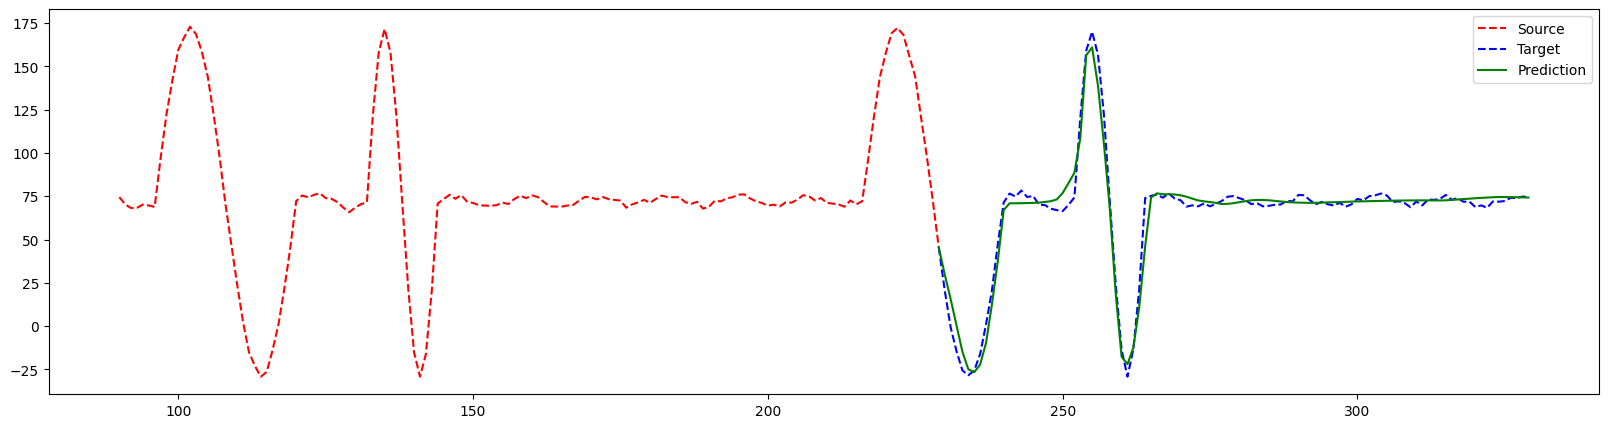

In [11]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

In [12]:
inspect_step = 0

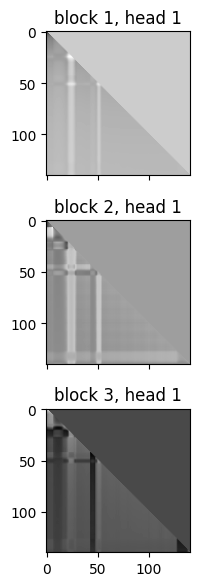

In [13]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

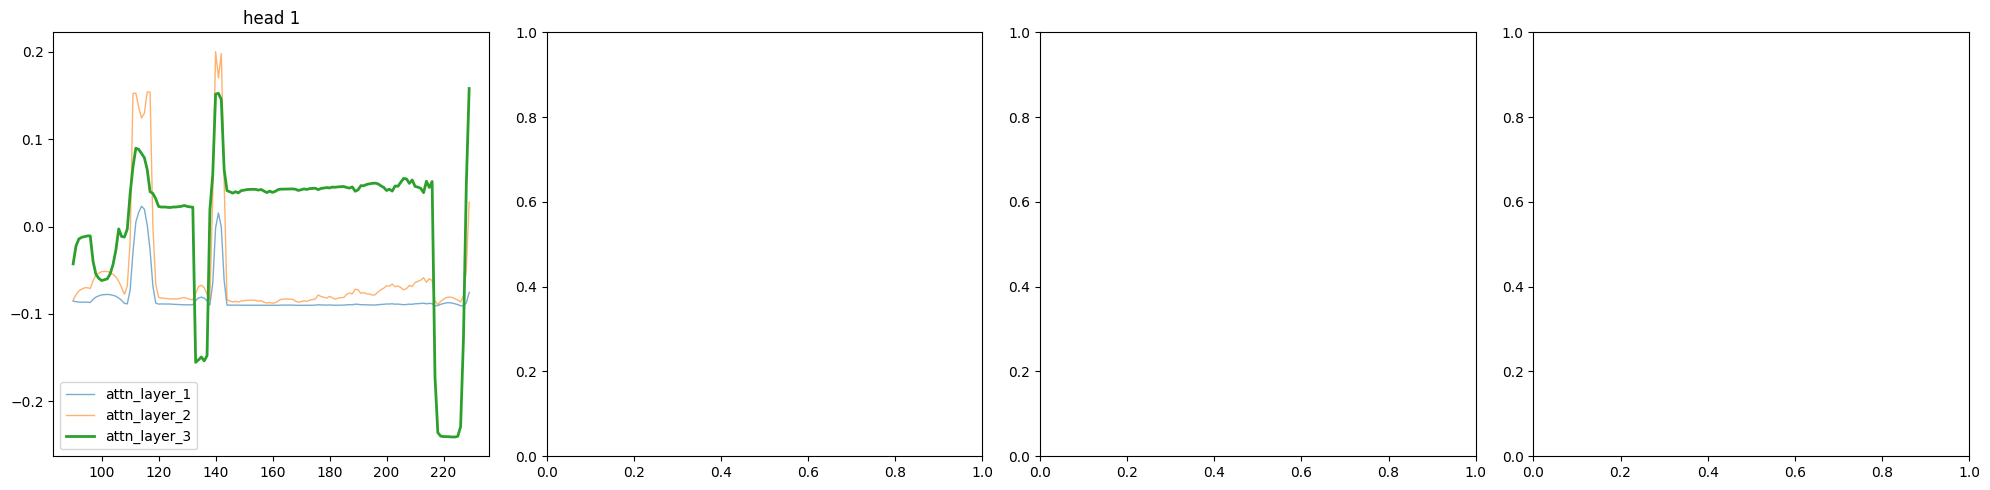

In [14]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -1, :].cpu() # index (inspect_step, attn_layer_i, sample_0, head_j, last row, :)
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

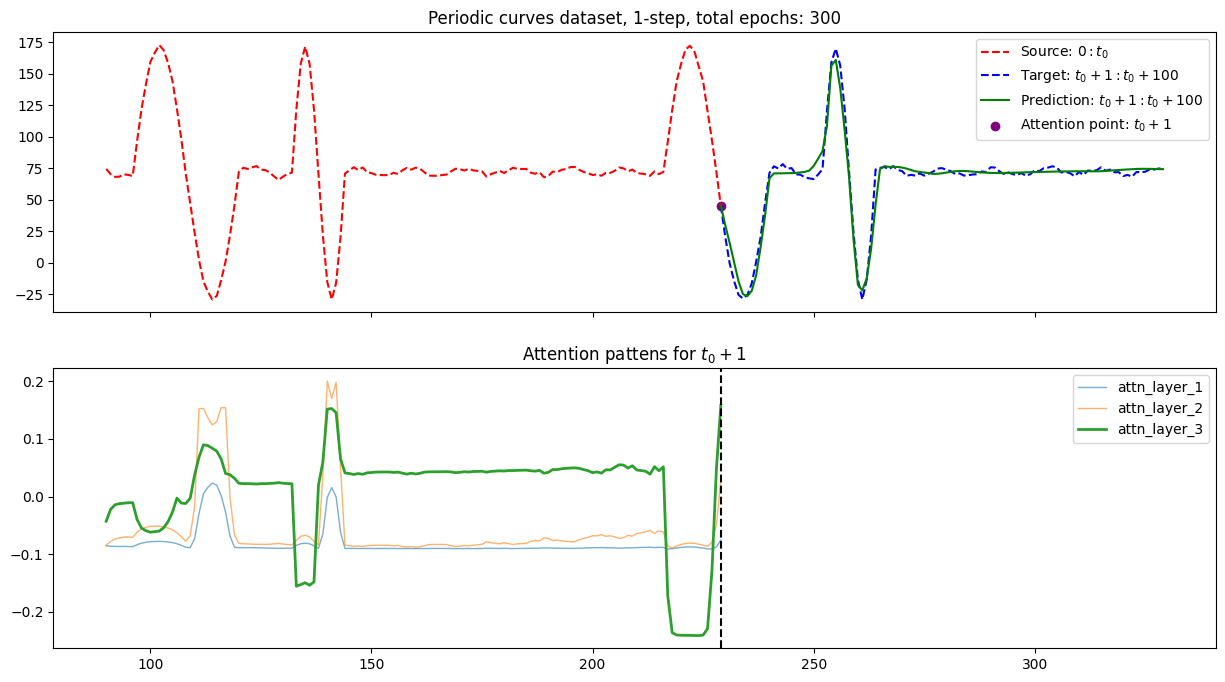

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_1pred_at_once.pdf", dpi=1200)

## Experiment 2: $n$-step prediction on `SimplePeriodicDataset` with overlapping source and target

In [16]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

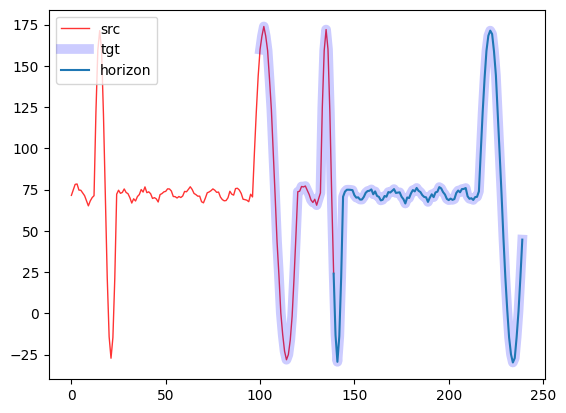

In [17]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [18]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [19]:
for epoch in range(EPOCHS):
    
    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2220.7489	val_loss=1501.8501	train_mape_loss=3.4943	val_mape_loss=4.3061	R_p=['0.2785', '0.2606']
epoch=1	train_loss=1522.9452	val_loss=1496.7373	train_mape_loss=4.0153	val_mape_loss=4.2555	R_p=['0.2739', '0.2626']
epoch=2	train_loss=1521.8582	val_loss=1496.3950	train_mape_loss=4.0167	val_mape_loss=4.2468	R_p=['0.2735', '0.2635']
epoch=3	train_loss=1520.6766	val_loss=1495.7759	train_mape_loss=4.0116	val_mape_loss=4.2415	R_p=['0.2728', '0.2644']
epoch=4	train_loss=1519.1314	val_loss=1496.8069	train_mape_loss=4.0125	val_mape_loss=4.2733	R_p=['0.2740', '0.2600']
epoch=5	train_loss=1519.4458	val_loss=1496.0059	train_mape_loss=4.0064	val_mape_loss=4.2597	R_p=['0.2735', '0.2617']
epoch=6	train_loss=1518.9200	val_loss=1499.3958	train_mape_loss=4.0090	val_mape_loss=4.2951	R_p=['0.2758', '0.2572']
epoch=7	train_loss=1518.9220	val_loss=1495.8794	train_mape_loss=4.0093	val_mape_loss=4.2627	R_p=['0.2736', '0.2607']
epoch=8	train_loss=1518.4227	val_loss=1494.4290	train_mape_loss=

In [20]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [21]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(131.52903173828125,
 0.6396012010574341,
 [0.060655247420072556, 0.049783866852521896])

In [22]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once.pth"
torch.save(best_model.state_dict(), path)

In [23]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, 0, device)

best_test_loss, best_test_mape_loss, best_r_ps

(127.47815020751953,
 0.62342795419693,
 tensor([0.0611, 0.0463], device='cuda:0'))

### Predict

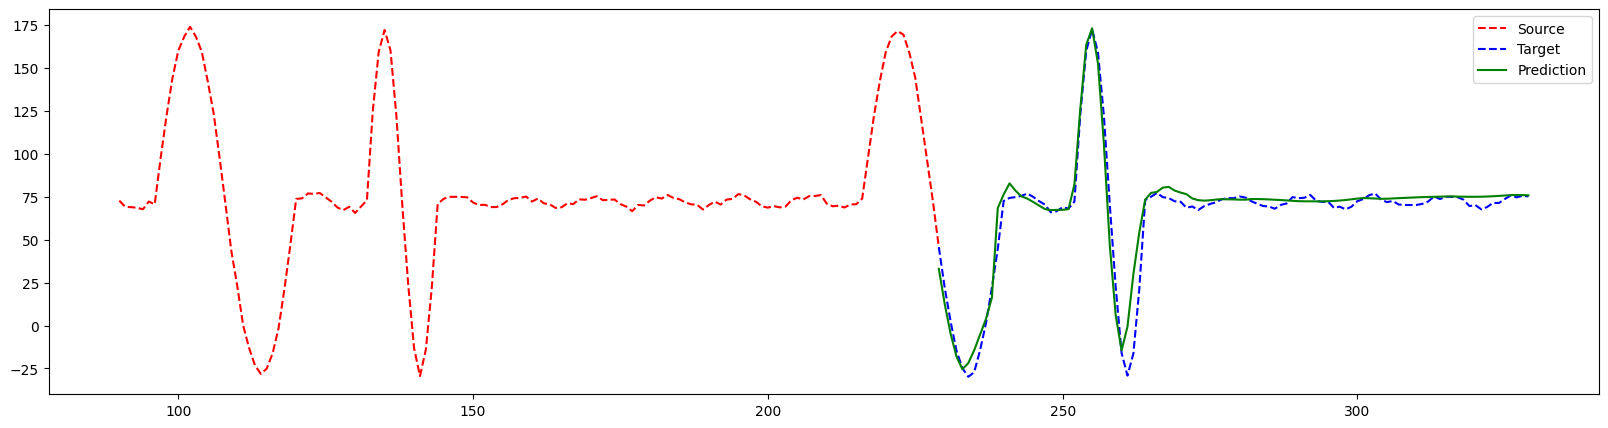

In [24]:
idx = 90
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift-1:].squeeze().cpu()
    
    tgt_X = tgt_X[:, -shift-1:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift-1:].squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [25]:
inspect_step = 0

In [26]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

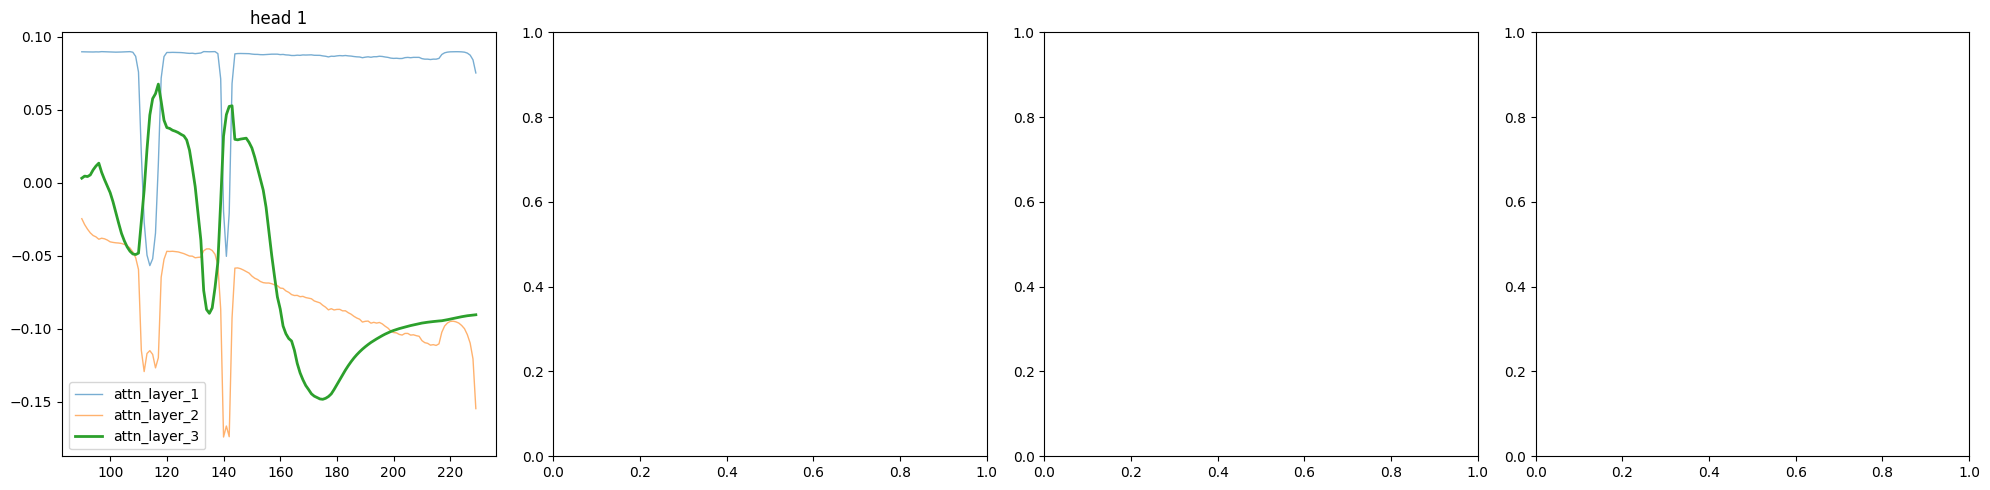

In [27]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

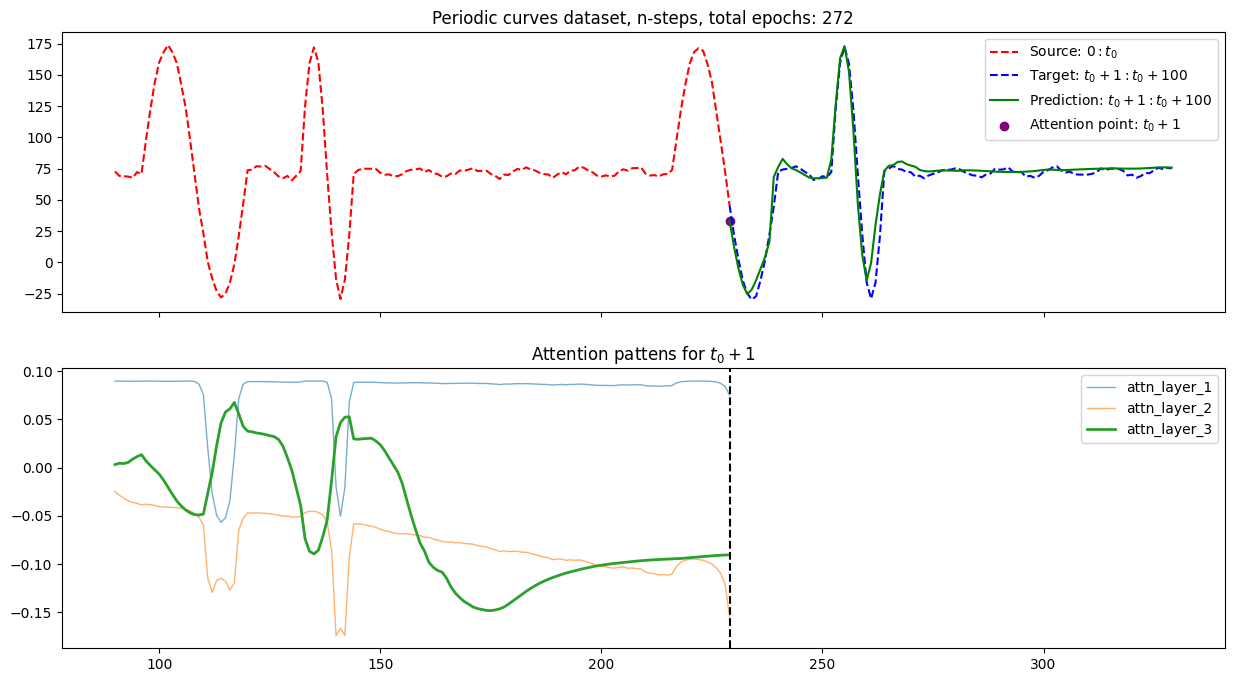

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, n-steps, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
    ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")

ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once.pdf", dpi=1200)

## Experiment 3: $n$-step prediction on `SimplePeriodicDataset` with non-overlapping source and target

In [29]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

In [30]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [31]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [32]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2069.1377	val_loss=1512.8651	train_mape_loss=4.0629	val_mape_loss=5.9254	R_p=['0.2866', '0.2565']
epoch=1	train_loss=1527.0271	val_loss=1504.7500	train_mape_loss=4.4930	val_mape_loss=5.8920	R_p=['0.2782', '0.2569']
epoch=2	train_loss=1522.8088	val_loss=1506.8928	train_mape_loss=4.5072	val_mape_loss=5.8984	R_p=['0.2808', '0.2548']
epoch=3	train_loss=1521.5877	val_loss=1502.9470	train_mape_loss=4.5030	val_mape_loss=5.8021	R_p=['0.2755', '0.2608']
epoch=4	train_loss=1520.8731	val_loss=1502.7958	train_mape_loss=4.5065	val_mape_loss=5.7964	R_p=['0.2755', '0.2607']
epoch=5	train_loss=1519.6713	val_loss=1501.5673	train_mape_loss=4.5077	val_mape_loss=5.8030	R_p=['0.2737', '0.2649']
epoch=6	train_loss=1519.7376	val_loss=1502.4166	train_mape_loss=4.5065	val_mape_loss=5.8338	R_p=['0.2748', '0.2618']
epoch=7	train_loss=1519.2982	val_loss=1511.9794	train_mape_loss=4.5150	val_mape_loss=5.7319	R_p=['0.2749', '0.2724']
epoch=8	train_loss=1519.7537	val_loss=1503.4144	train_mape_loss=

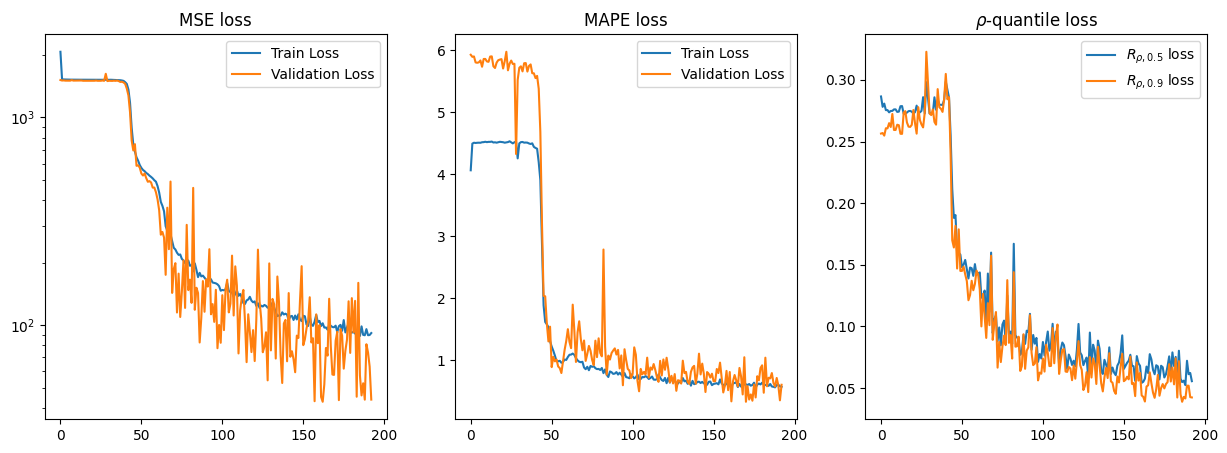

In [33]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [34]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(44.34329885864258,
 0.4265320768356323,
 [0.055645652115345, 0.04282324016094208])

In [35]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [36]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(42.61002932739258,
 0.48336785507202146,
 tensor([0.0550, 0.0428], device='cuda:0'))

### Predict

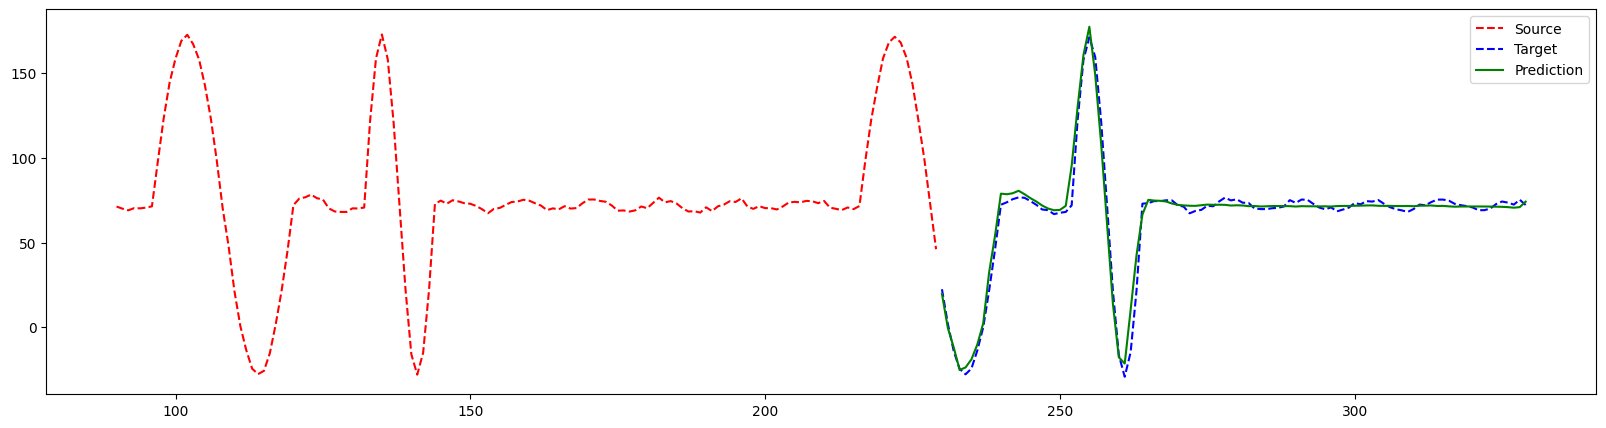

In [37]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [38]:
inspect_step = 0

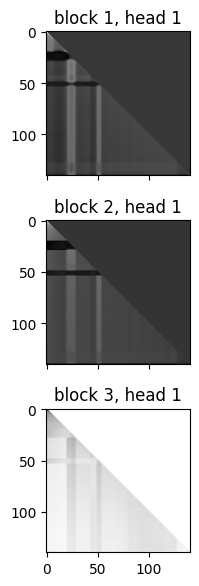

In [39]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

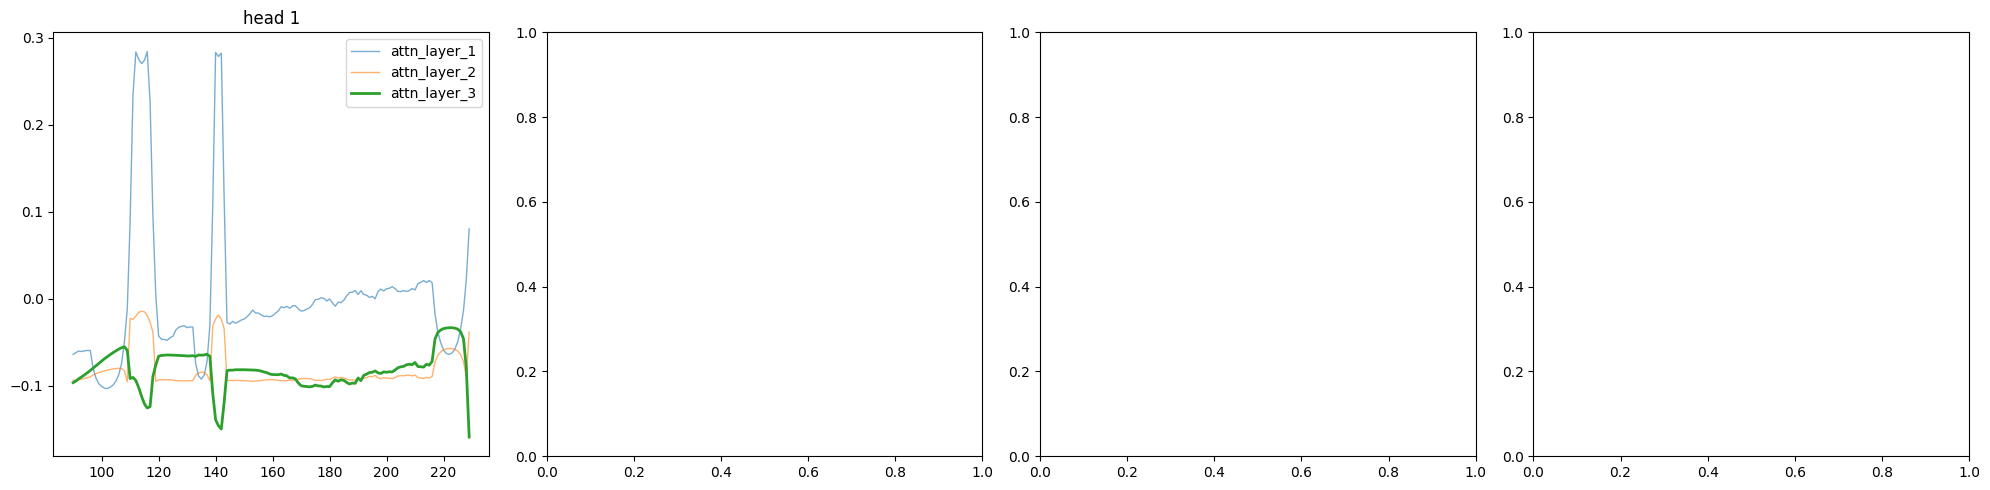

In [40]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

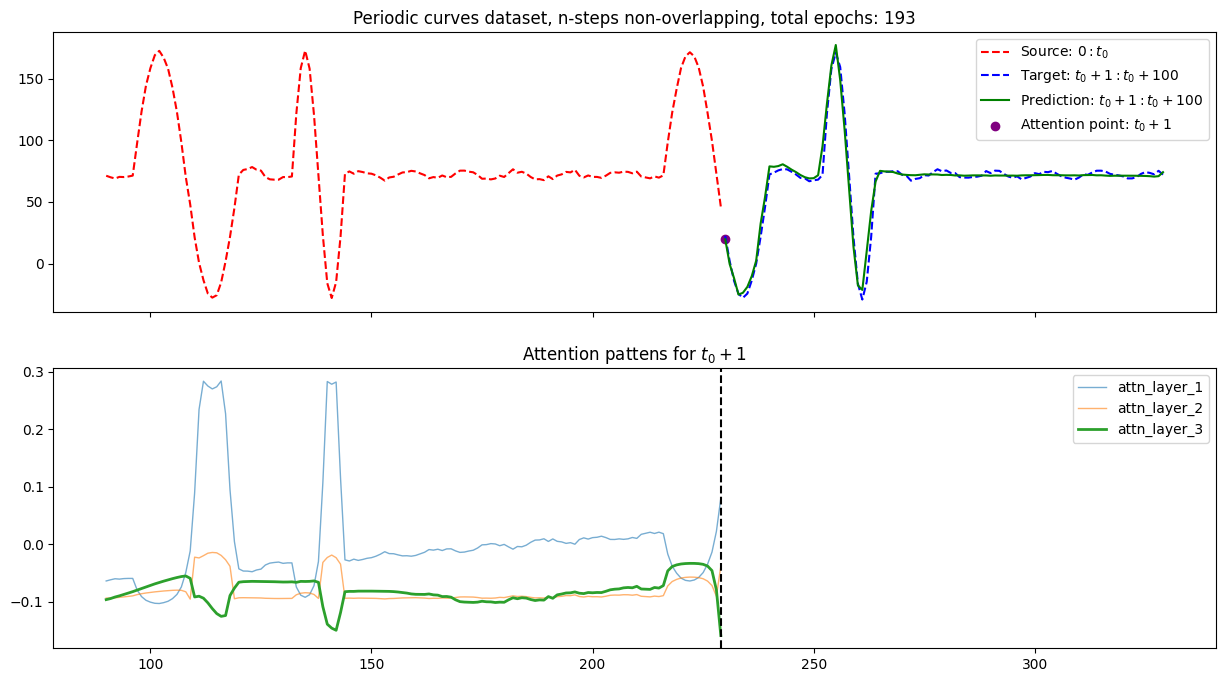

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 4: $n$-step prediction on `MultivarPeriodicDataset` with non-overlapping source and target and $m$ time series

In [42]:
DATASET_NAME = "multivar_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 100                      # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultivarPeriodicDataset(len_timeseries=total_length, n_timeseries=n_timeseries, seq_len=seq_len, shift=shift, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 100]),
 torch.Size([100, 1]),
 torch.Size([100, 100]))

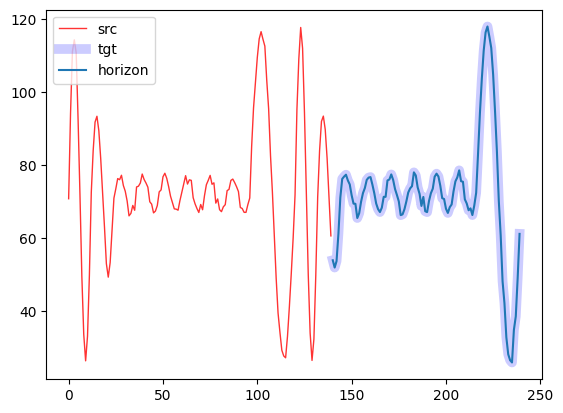

In [43]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

ith = 0 # i-th time series

plt.plot(src_X, src_fX[:, ith], 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX[:, ith], '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:, ith], tgt_fX[-shift-1:, ith], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

### Training setup

In [44]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [45]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=1785.3673	val_loss=641.7279	train_mape_loss=0.5279	val_mape_loss=0.3981	R_p=['0.2730', '0.2623']
epoch=1	train_loss=693.6795	val_loss=642.5751	train_mape_loss=0.4051	val_mape_loss=0.4022	R_p=['0.2736', '0.2561']
epoch=2	train_loss=681.3158	val_loss=641.4818	train_mape_loss=0.4030	val_mape_loss=0.3996	R_p=['0.2729', '0.2593']
epoch=3	train_loss=674.1125	val_loss=642.7176	train_mape_loss=0.4015	val_mape_loss=0.4028	R_p=['0.2737', '0.2553']
epoch=4	train_loss=668.5861	val_loss=639.9345	train_mape_loss=0.4004	val_mape_loss=0.3922	R_p=['0.2717', '0.2710']
epoch=5	train_loss=665.2327	val_loss=640.8171	train_mape_loss=0.3996	val_mape_loss=0.3977	R_p=['0.2724', '0.2620']
epoch=6	train_loss=662.6216	val_loss=639.8860	train_mape_loss=0.3992	val_mape_loss=0.3911	R_p=['0.2717', '0.2730']
epoch=7	train_loss=660.8645	val_loss=640.5891	train_mape_loss=0.3987	val_mape_loss=0.3970	R_p=['0.2723', '0.2626']
epoch=8	train_loss=659.6705	val_loss=640.4084	train_mape_loss=0.3984	val_mape_l

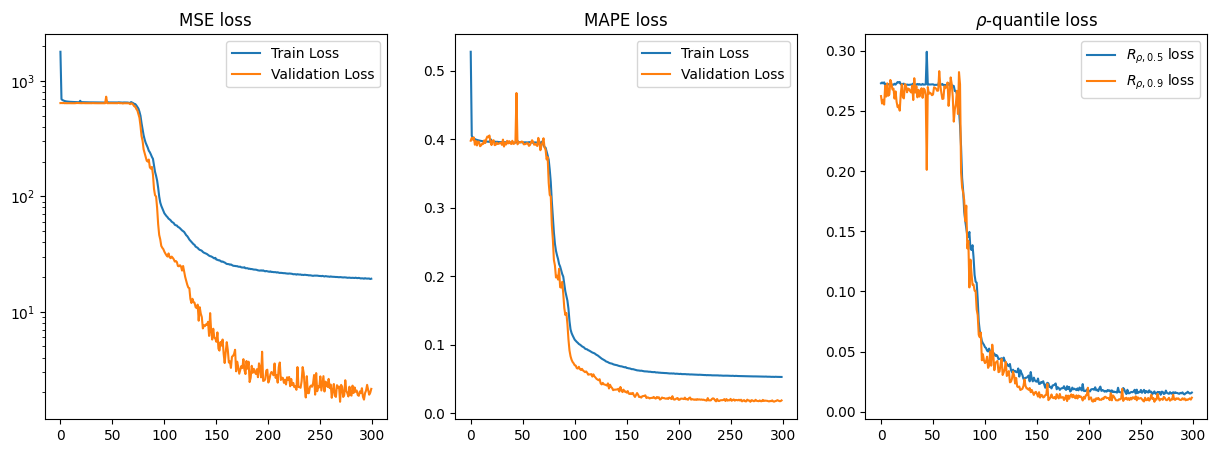

In [46]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [47]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(2.168716241836548,
 0.0189287046790123,
 [0.015995703637599945, 0.011695566587150097])

In [48]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [49]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(1.6682938585281373,
 0.016916106075048447,
 tensor([0.0141, 0.0106], device='cuda:0'))

### Predict

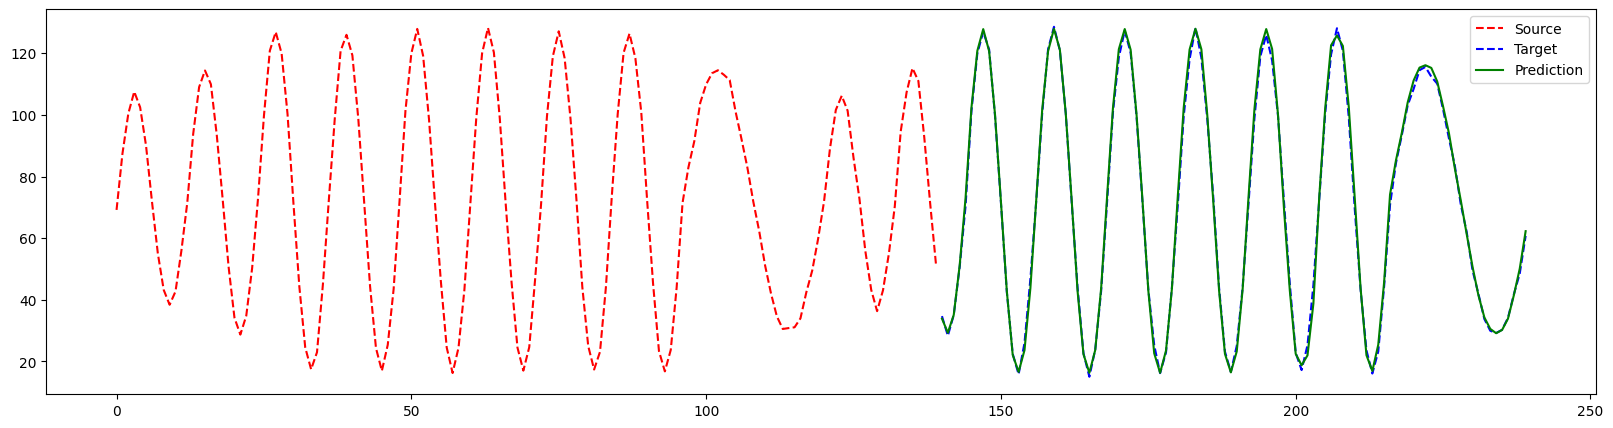

In [50]:
idx = 0 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

ith = 3

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu()[:, ith], '--r', label="Source")
plt.plot(tgt_X, tgt_fX[:, ith], '--b', label="Target")
plt.plot(tgt_X, pred_fX[:, ith], '-g', label="Prediction")
plt.legend()

In [51]:
inspect_step = 0

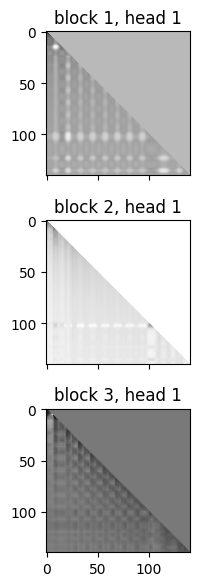

In [52]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

In [53]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

In [54]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu()[:, ith], '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX[:, ith], '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX[:, ith], '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step, ith].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Multivariate Periodic curves dataset, n-steps non-overlapping, {ith}-th time series, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 5: $n$-step prediction on `(Decaying/Multi)StepSyntheticDataset` with non-overlapping source and target

### Step function

In [55]:
DATASET_NAME = "step"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.StepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

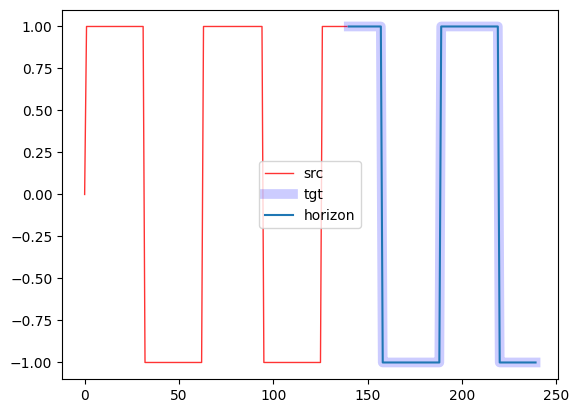

In [56]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [57]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden*2,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [58]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=1.1136	val_loss=1.0036	train_mape_loss=1.0092	val_mape_loss=1.0004	R_p=['1.0004', '0.9501']
epoch=1	train_loss=1.0141	val_loss=1.0035	train_mape_loss=1.0001	val_mape_loss=1.0005	R_p=['1.0005', '0.9526']
epoch=2	train_loss=1.0098	val_loss=1.0016	train_mape_loss=0.9998	val_mape_loss=1.0003	R_p=['1.0003', '0.9673']
epoch=3	train_loss=1.0085	val_loss=1.0041	train_mape_loss=0.9998	val_mape_loss=0.9992	R_p=['0.9992', '1.0510']
epoch=4	train_loss=1.0072	val_loss=1.0212	train_mape_loss=1.0001	val_mape_loss=0.9984	R_p=['0.9984', '1.1152']
epoch=5	train_loss=1.0072	val_loss=1.0000	train_mape_loss=1.0002	val_mape_loss=1.0000	R_p=['1.0000', '0.9899']
epoch=6	train_loss=1.0057	val_loss=1.0023	train_mape_loss=1.0000	val_mape_loss=0.9994	R_p=['0.9994', '1.0380']
epoch=7	train_loss=1.0050	val_loss=1.0010	train_mape_loss=1.0001	val_mape_loss=0.9995	R_p=['0.9995', '1.0262']
epoch=8	train_loss=1.0043	val_loss=1.0004	train_mape_loss=0.9997	val_mape_loss=0.9996	R_p=['0.9996', '1.0180']
e

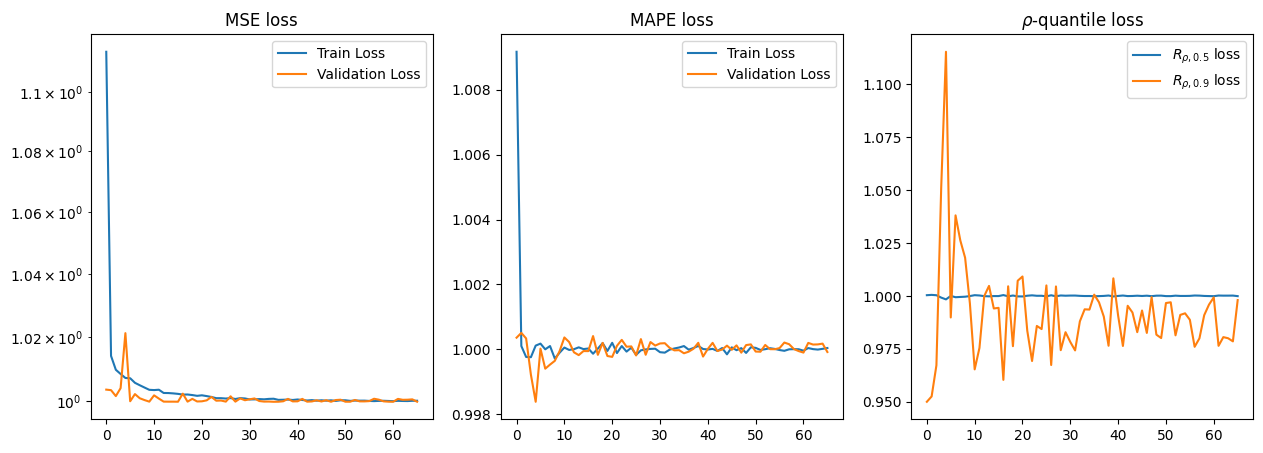

In [59]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [60]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(1.0000866746902466,
 1.0000104379653931,
 [1.0000104904174805, 1.0076639652252197])

In [61]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [62]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(1.0001580200195312,
 1.0000146055221557,
 tensor([1.0000, 1.0103], device='cuda:0'))

#### Predict

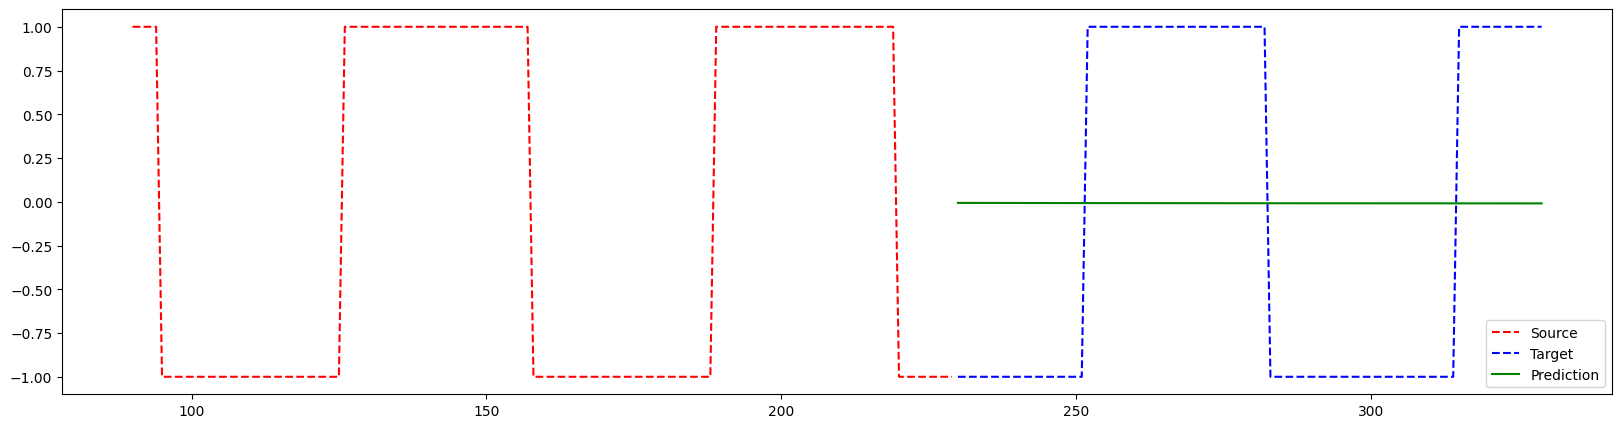

In [63]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [64]:
inspect_step = 0

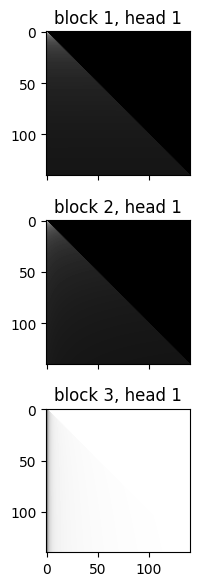

In [65]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

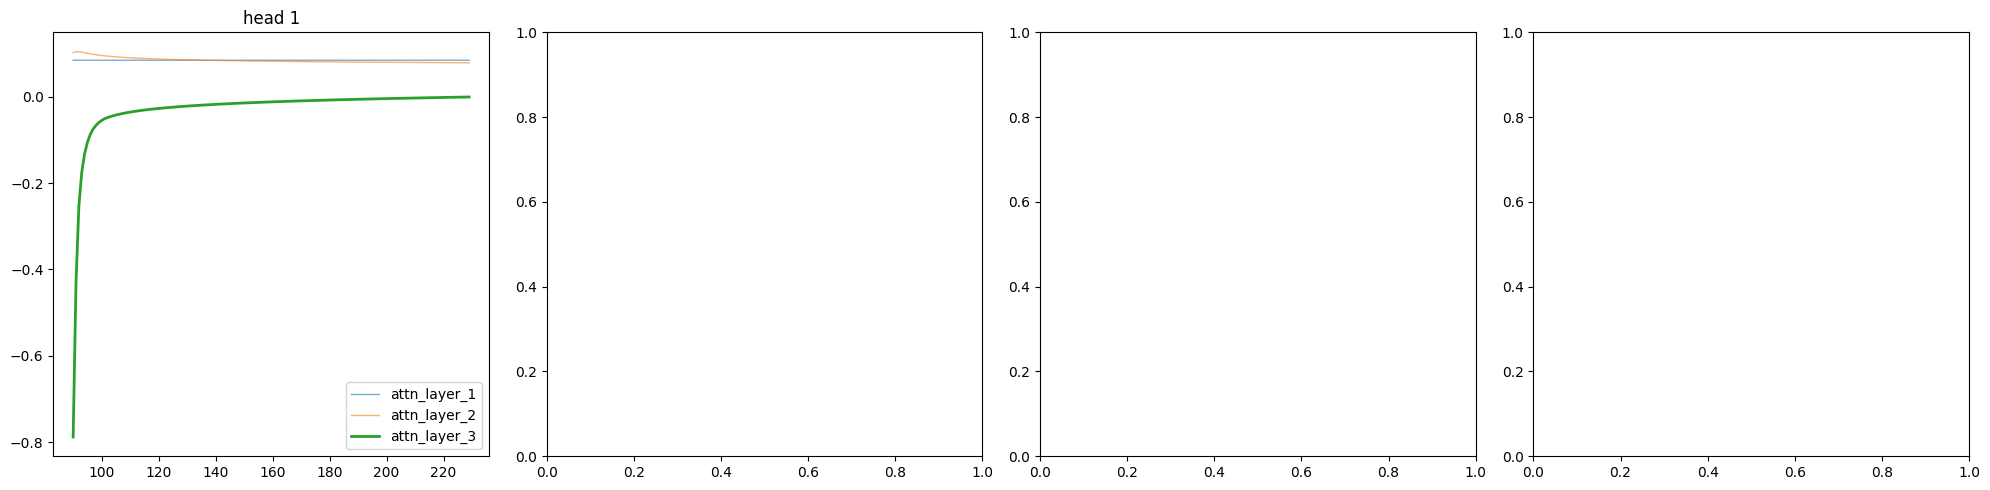

In [66]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

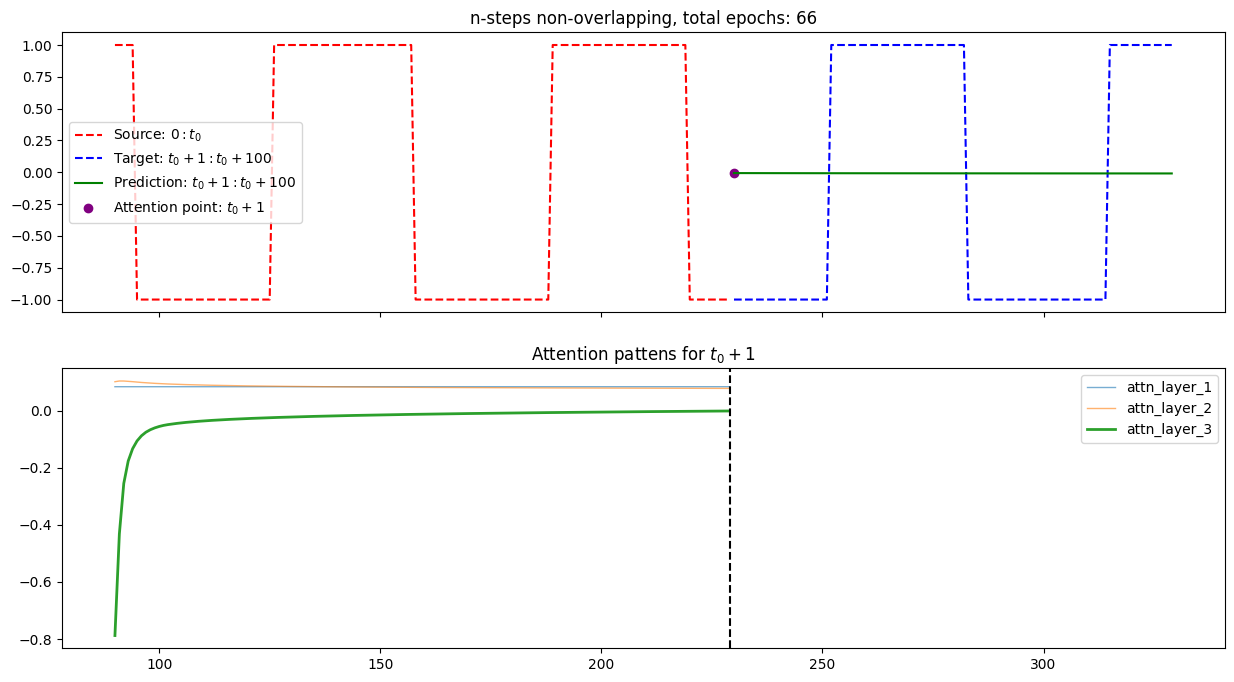

In [67]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Step function

In [68]:
DATASET_NAME = "step_decay"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.DecayingStepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

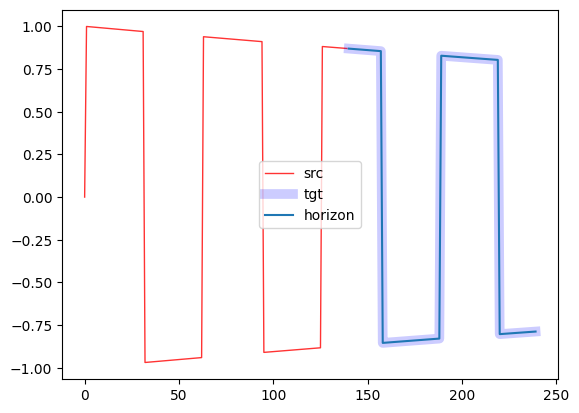

In [69]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [70]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [71]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.1672	val_loss=0.0682	train_mape_loss=17.5144	val_mape_loss=7.6233	R_p=['1.2987', '1.7841']
epoch=1	train_loss=0.0697	val_loss=0.0603	train_mape_loss=7.1601	val_mape_loss=1.6761	R_p=['1.0187', '0.9962']
epoch=2	train_loss=0.0649	val_loss=0.0602	train_mape_loss=5.6921	val_mape_loss=1.3465	R_p=['1.0080', '1.0482']
epoch=3	train_loss=0.0619	val_loss=0.0602	train_mape_loss=4.6416	val_mape_loss=1.2979	R_p=['1.0067', '1.0438']
epoch=4	train_loss=0.0608	val_loss=0.0607	train_mape_loss=4.1480	val_mape_loss=2.3290	R_p=['1.0424', '0.9033']
epoch=5	train_loss=0.0603	val_loss=0.0602	train_mape_loss=3.9201	val_mape_loss=1.0828	R_p=['1.0018', '0.9671']
epoch=6	train_loss=0.0596	val_loss=0.0613	train_mape_loss=3.5432	val_mape_loss=3.3756	R_p=['1.0819', '1.2745']
epoch=7	train_loss=0.0601	val_loss=0.0604	train_mape_loss=3.7265	val_mape_loss=1.9862	R_p=['1.0282', '1.1198']
epoch=8	train_loss=0.0591	val_loss=0.0602	train_mape_loss=3.2403	val_mape_loss=1.0226	R_p=['1.0003', '1.0055']


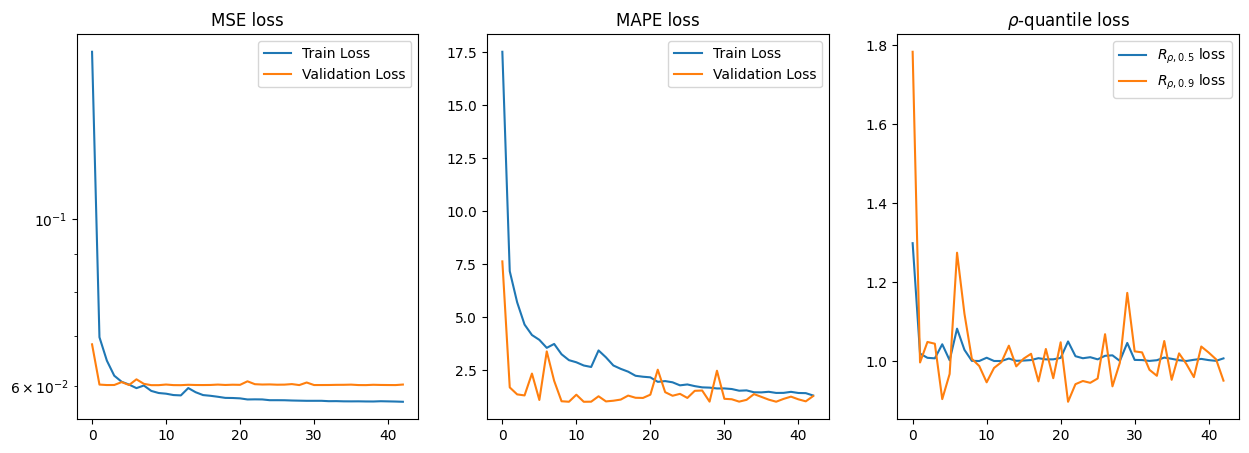

In [72]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [73]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.056268010228872296,
 1.29131388092041,
 [1.0066348314285278, 0.9609813690185547])

In [74]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [75]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.05619452893733978,
 1.0003871650695801,
 tensor([1.0000, 1.0095], device='cuda:0'))

#### Predict

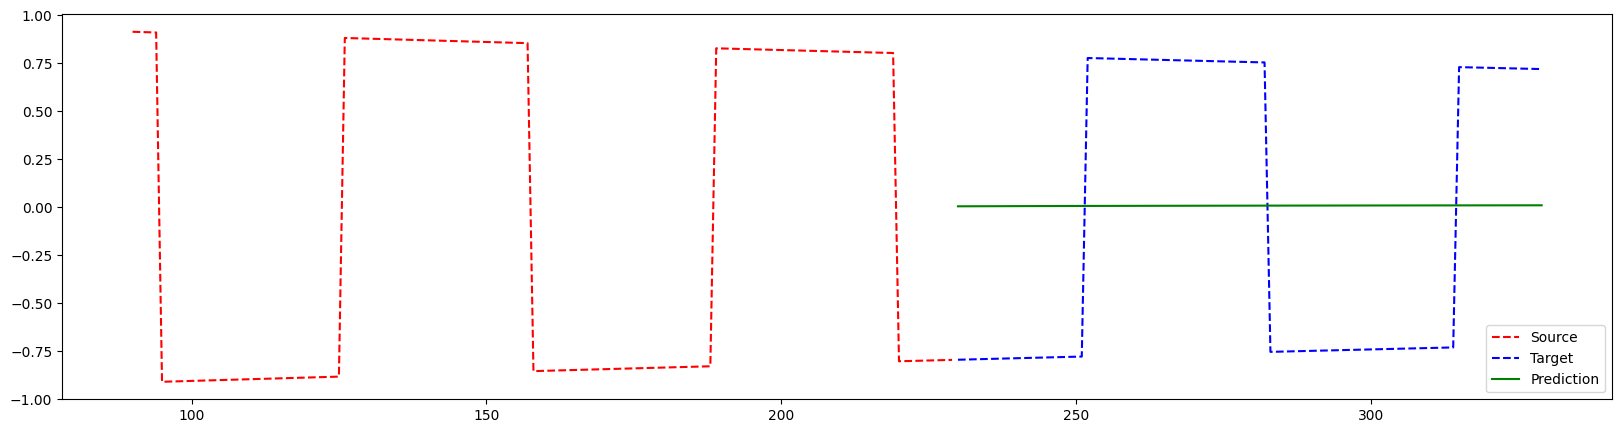

In [76]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [77]:
inspect_step = 0

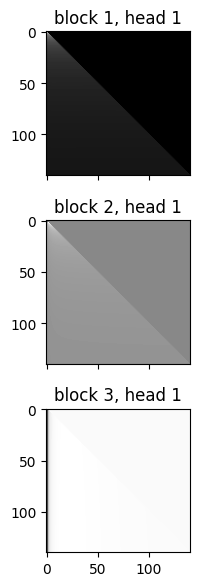

In [78]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

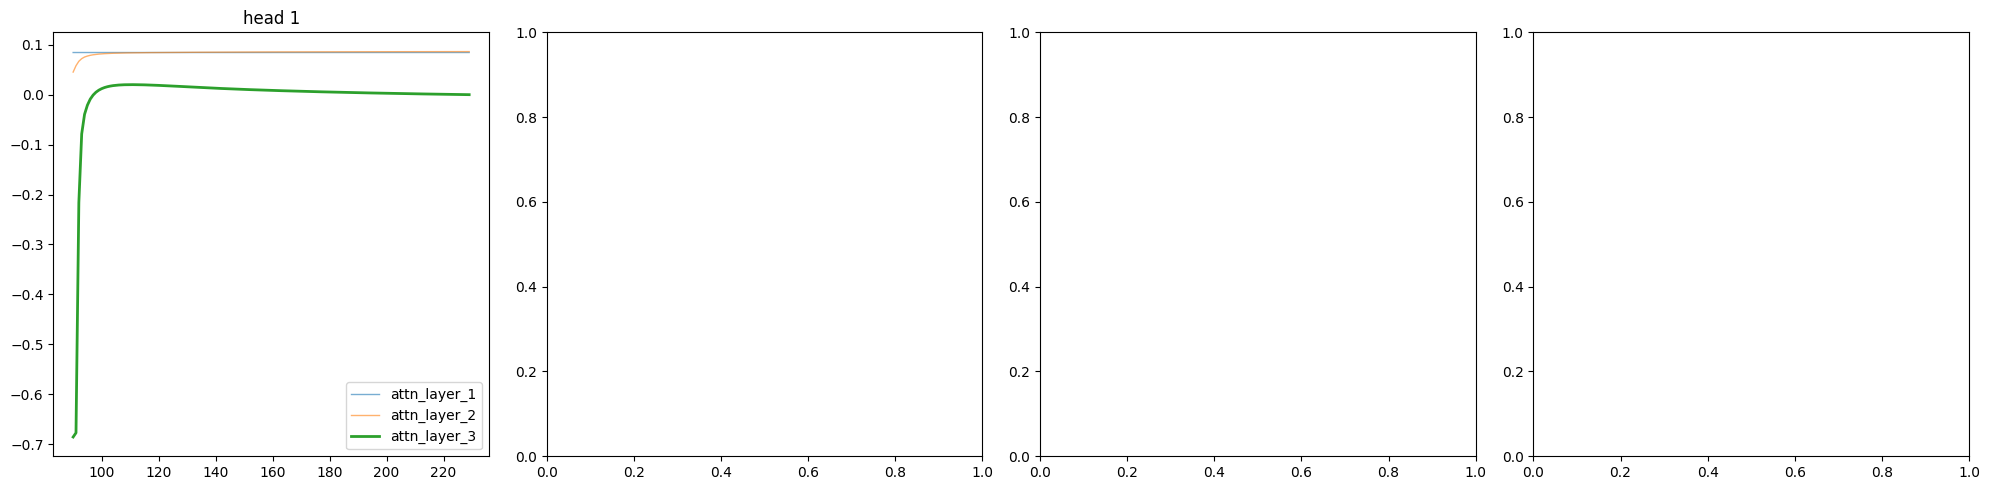

In [79]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

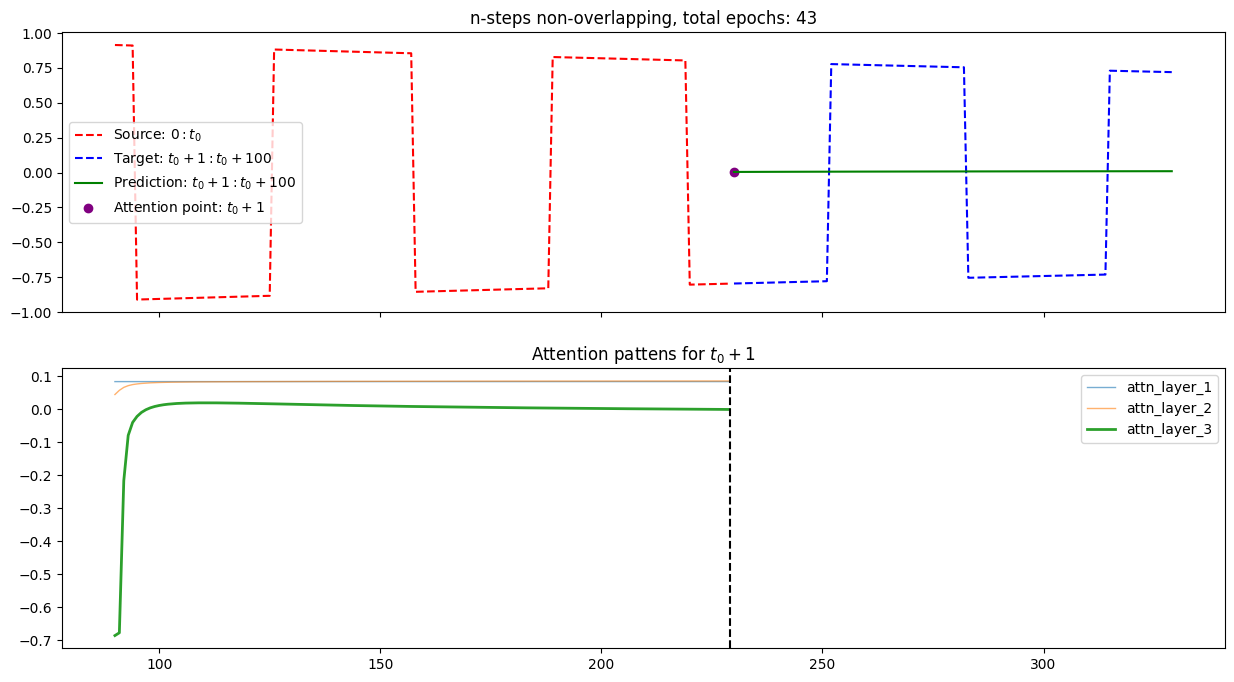

In [80]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Step function

In [81]:
DATASET_NAME = "step_multi"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultipleStepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

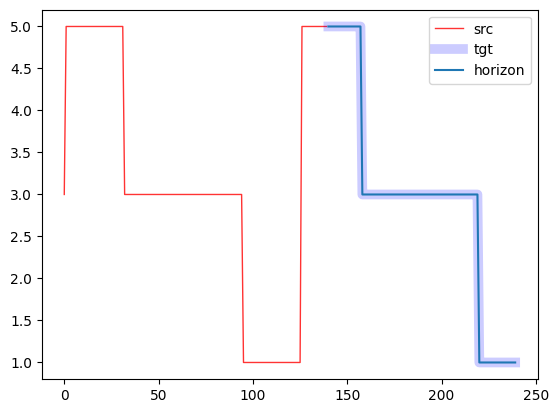

In [82]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [83]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [84]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2.2335	val_loss=2.0488	train_mape_loss=0.6491	val_mape_loss=0.6843	R_p=['0.3710', '0.3080']
epoch=1	train_loss=2.0449	val_loss=1.9970	train_mape_loss=0.6266	val_mape_loss=0.6225	R_p=['0.3428', '0.3246']
epoch=2	train_loss=2.0384	val_loss=2.0034	train_mape_loss=0.6248	val_mape_loss=0.5946	R_p=['0.3522', '0.3832']
epoch=3	train_loss=2.0313	val_loss=1.9916	train_mape_loss=0.6219	val_mape_loss=0.6088	R_p=['0.3367', '0.3283']
epoch=4	train_loss=2.0300	val_loss=1.9921	train_mape_loss=0.6213	val_mape_loss=0.5964	R_p=['0.3410', '0.3544']
epoch=5	train_loss=2.0297	val_loss=1.9986	train_mape_loss=0.6214	val_mape_loss=0.5953	R_p=['0.3480', '0.3724']
epoch=6	train_loss=2.0292	val_loss=1.9991	train_mape_loss=0.6214	val_mape_loss=0.5954	R_p=['0.3488', '0.3742']
epoch=7	train_loss=2.0255	val_loss=1.9940	train_mape_loss=0.6194	val_mape_loss=0.6202	R_p=['0.3421', '0.3254']
epoch=8	train_loss=2.0259	val_loss=1.9903	train_mape_loss=0.6205	val_mape_loss=0.6000	R_p=['0.3328', '0.3308']
e

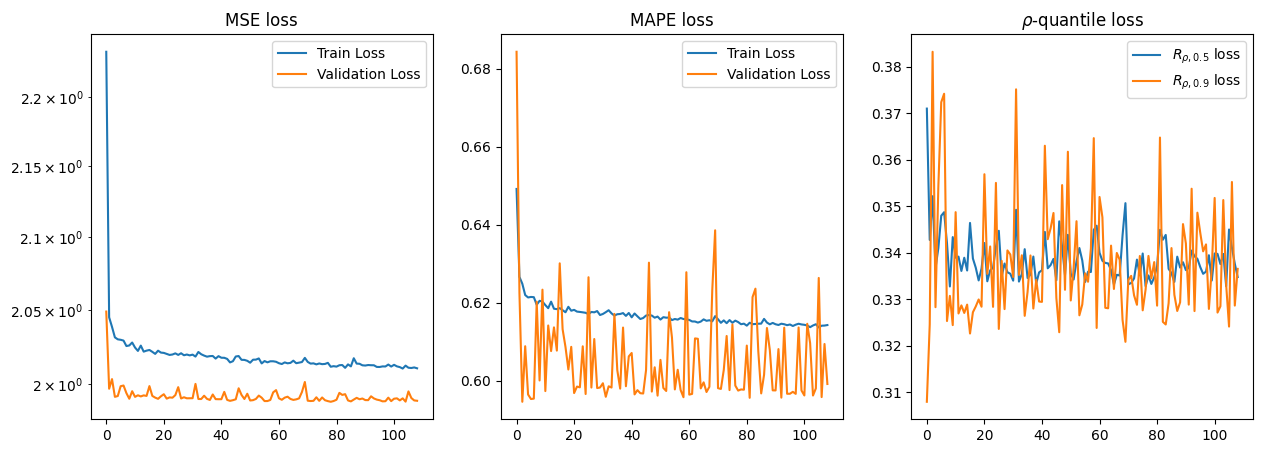

In [85]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [86]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(2.0008635749816897,
 0.5956373209953308,
 [0.33533671498298645, 0.34218376874923706])

In [87]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [88]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(2.0023858051300047,
 0.5951393728256226,
 tensor([0.3342, 0.3401], device='cuda:0'))

#### Predict

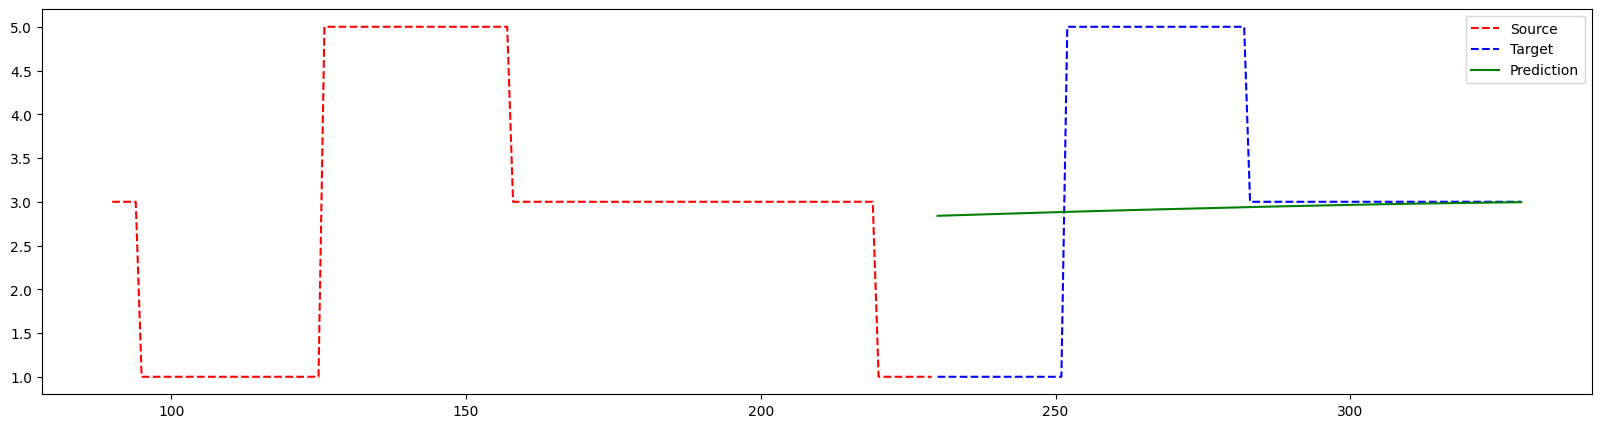

In [89]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [90]:
inspect_step = 0

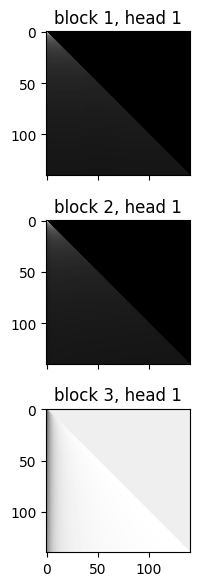

In [91]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

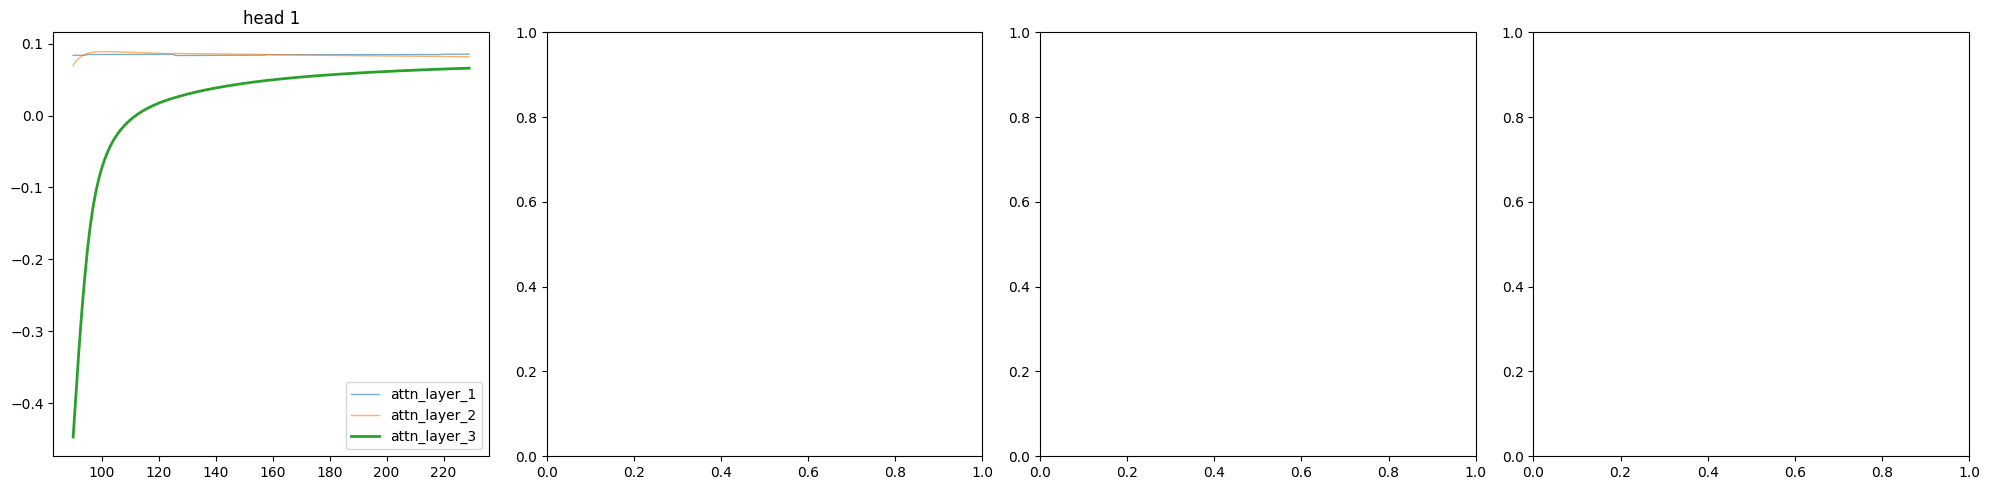

In [92]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

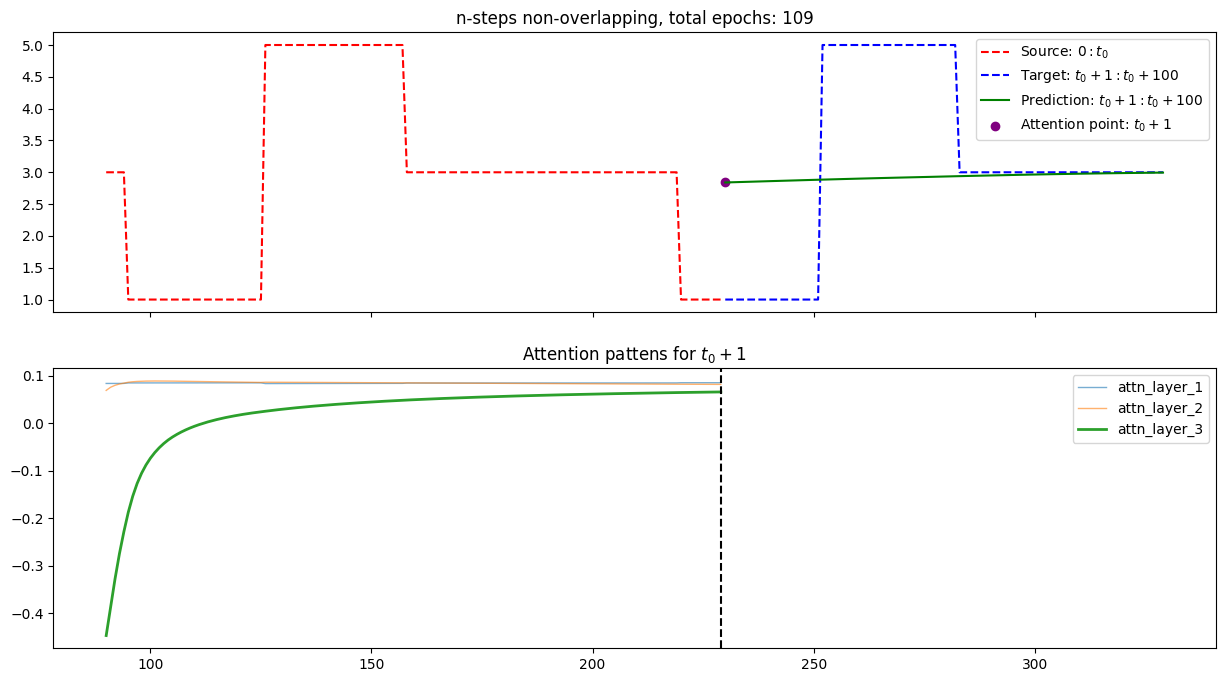

In [93]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 6: $n$-step prediction on `(Decaying/Multi)SineSyntheticDataset` with non-overlapping source and target

### Sine function

In [94]:
DATASET_NAME = "sine"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

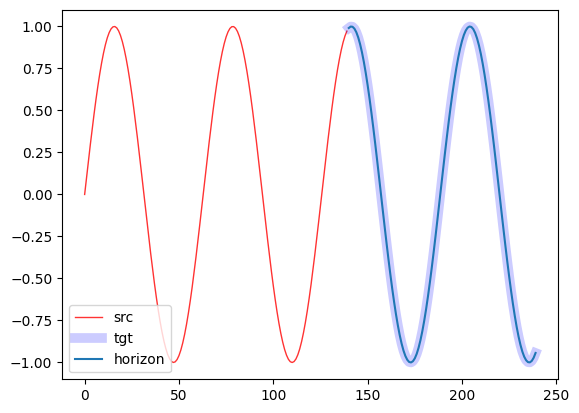

In [95]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [96]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [97]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.6140	val_loss=0.5045	train_mape_loss=2.8475	val_mape_loss=1.4330	R_p=['1.0021', '0.9250']
epoch=1	train_loss=0.5130	val_loss=0.5117	train_mape_loss=1.7200	val_mape_loss=1.8030	R_p=['1.0059', '0.8744']
epoch=2	train_loss=0.5093	val_loss=0.5092	train_mape_loss=1.6269	val_mape_loss=1.6922	R_p=['1.0046', '0.8887']
epoch=3	train_loss=0.5073	val_loss=0.5008	train_mape_loss=1.5713	val_mape_loss=1.0458	R_p=['1.0001', '0.9856']
epoch=4	train_loss=0.5063	val_loss=0.5033	train_mape_loss=1.4415	val_mape_loss=1.3488	R_p=['1.0015', '0.9376']
epoch=5	train_loss=0.5049	val_loss=0.5056	train_mape_loss=1.4480	val_mape_loss=1.5792	R_p=['1.0021', '1.0899']
epoch=6	train_loss=0.5046	val_loss=0.5024	train_mape_loss=1.4399	val_mape_loss=1.2614	R_p=['1.0010', '0.9502']
epoch=7	train_loss=0.5036	val_loss=0.5044	train_mape_loss=1.4008	val_mape_loss=1.4217	R_p=['1.0020', '0.9265']
epoch=8	train_loss=0.5033	val_loss=0.5013	train_mape_loss=1.3840	val_mape_loss=1.1399	R_p=['1.0004', '0.9697']
e

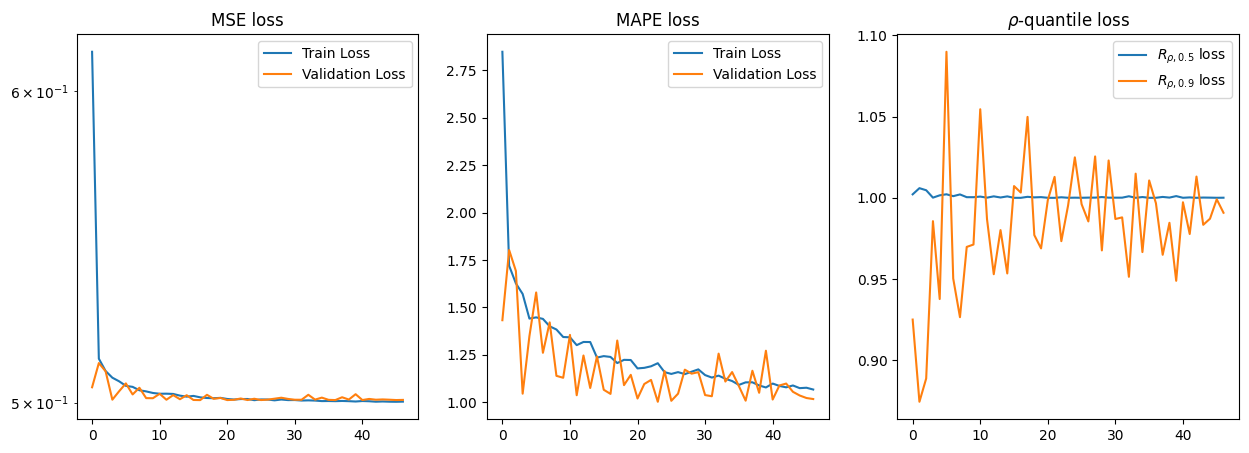

In [98]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [99]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.49934199476242064,
 1.0174727592468262,
 [0.9999908804893494, 0.9981202483177185])

In [100]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [101]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.49940740370750425,
 1.0459253015518188,
 tensor([1.0000, 1.0107], device='cuda:0'))

#### Predict

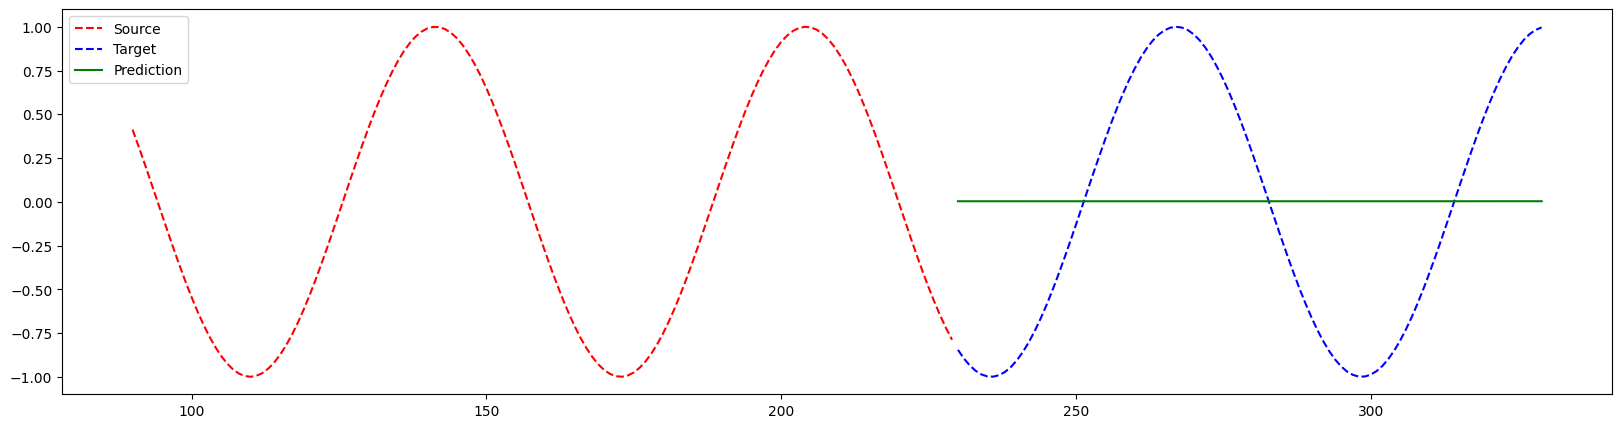

In [102]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [103]:
inspect_step = 0

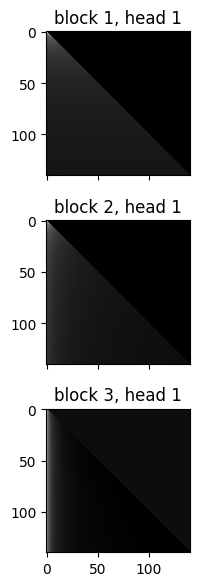

In [104]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

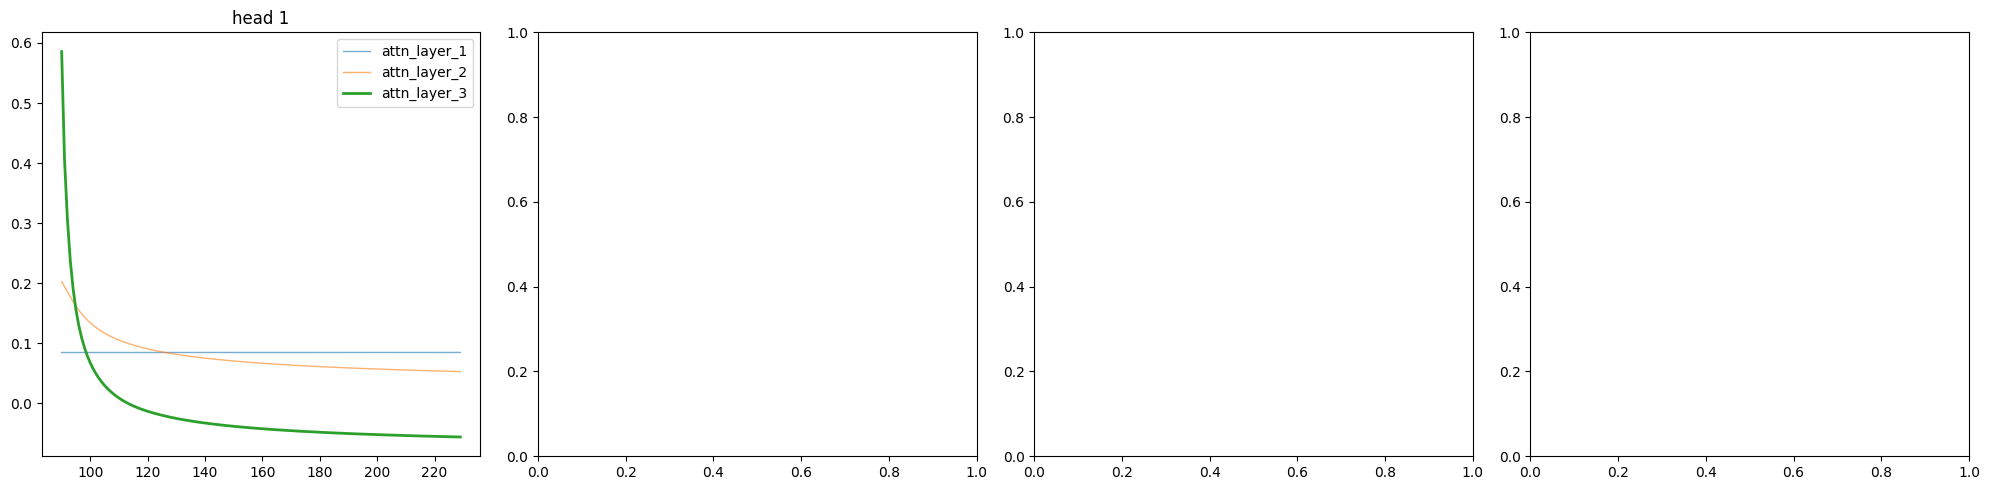

In [105]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

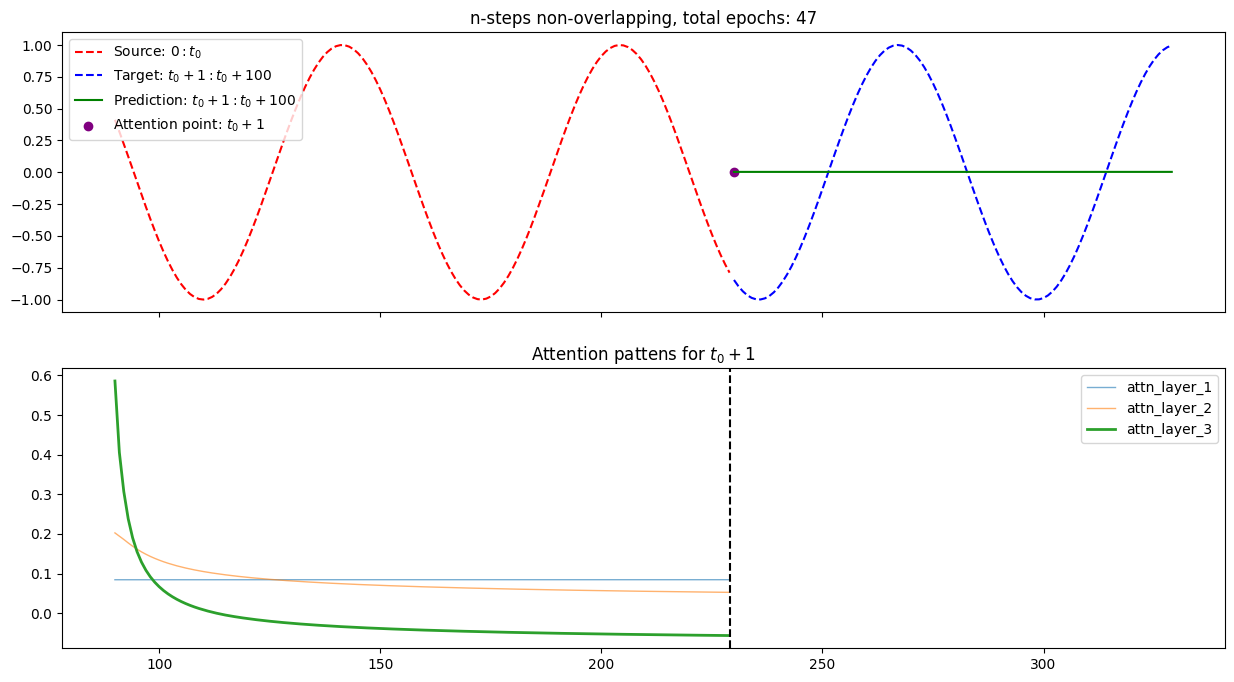

In [106]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Sine function

In [107]:
DATASET_NAME = "sine_decay"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.DecayingSineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

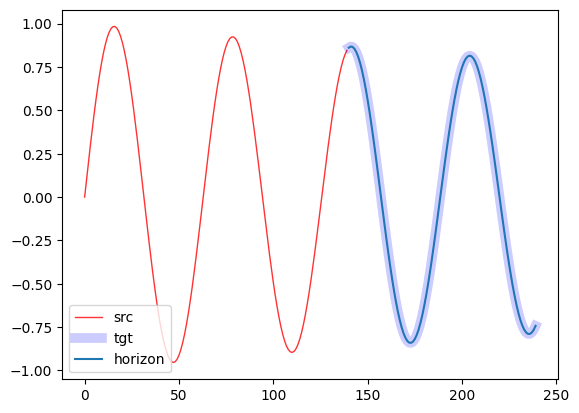

In [108]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [109]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [110]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.2060	val_loss=0.0340	train_mape_loss=150.7554	val_mape_loss=25.3880	R_p=['1.2080', '1.6011']
epoch=1	train_loss=0.0418	val_loss=0.0323	train_mape_loss=56.1923	val_mape_loss=10.9930	R_p=['1.0654', '1.2498']
epoch=2	train_loss=0.0368	val_loss=0.0318	train_mape_loss=44.9222	val_mape_loss=2.1637	R_p=['1.0036', '1.0516']
epoch=3	train_loss=0.0349	val_loss=0.0317	train_mape_loss=40.3174	val_mape_loss=2.8842	R_p=['1.0041', '0.9997']
epoch=4	train_loss=0.0336	val_loss=0.0318	train_mape_loss=36.2474	val_mape_loss=4.4554	R_p=['1.0141', '1.1022']
epoch=5	train_loss=0.0328	val_loss=0.0317	train_mape_loss=32.0321	val_mape_loss=4.5368	R_p=['1.0129', '0.9794']
epoch=6	train_loss=0.0322	val_loss=0.0318	train_mape_loss=30.6405	val_mape_loss=8.2697	R_p=['1.0387', '0.9470']
epoch=7	train_loss=0.0316	val_loss=0.0317	train_mape_loss=28.4514	val_mape_loss=1.6339	R_p=['1.0008', '1.0405']
epoch=8	train_loss=0.0310	val_loss=0.0321	train_mape_loss=26.9810	val_mape_loss=9.8141	R_p=['1.0538',

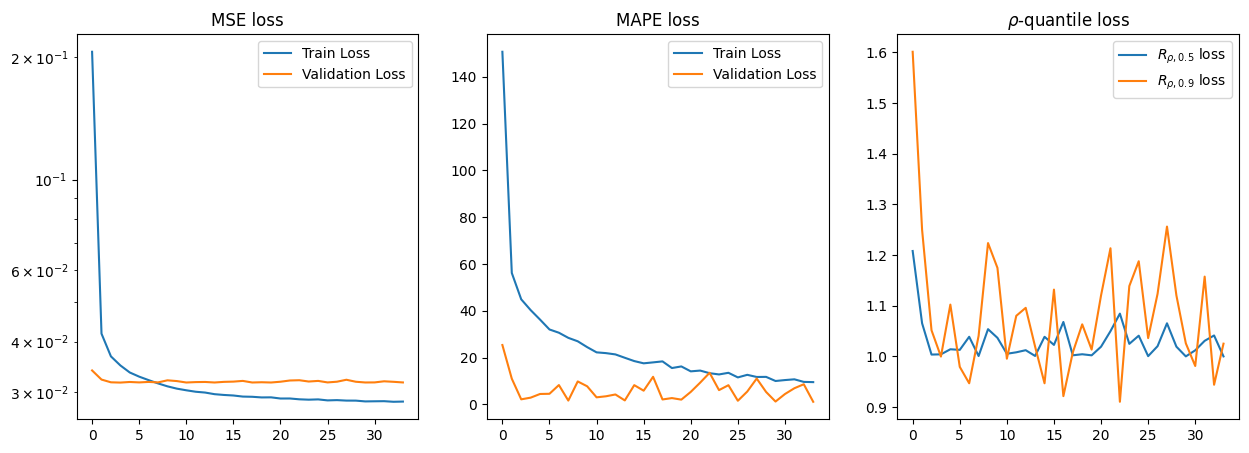

In [111]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [112]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.029231594502925874,
 1.1031615447998047,
 [1.0000370740890503, 0.9841735363006592])

In [113]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [114]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.029259112477302552,
 2.65481329536438,
 tensor([1.0055, 0.9593], device='cuda:0'))

#### Predict

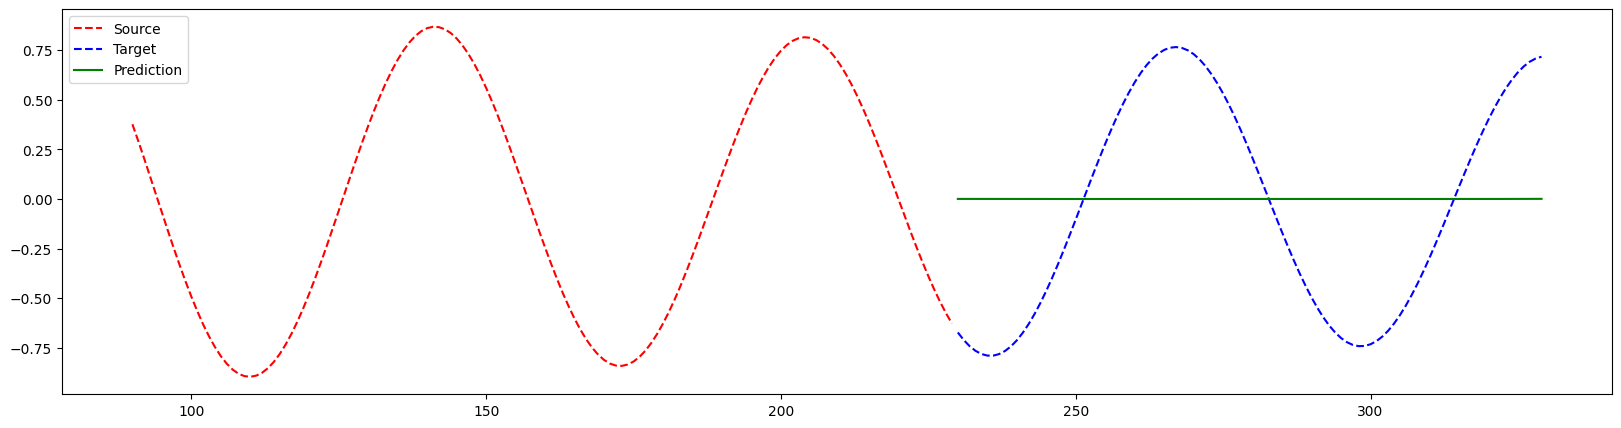

In [115]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [116]:
inspect_step = 0

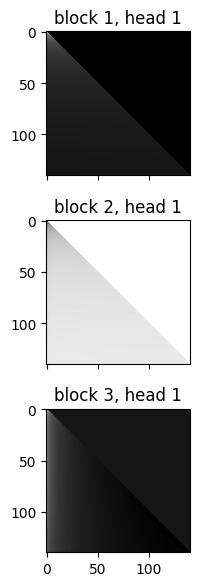

In [117]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

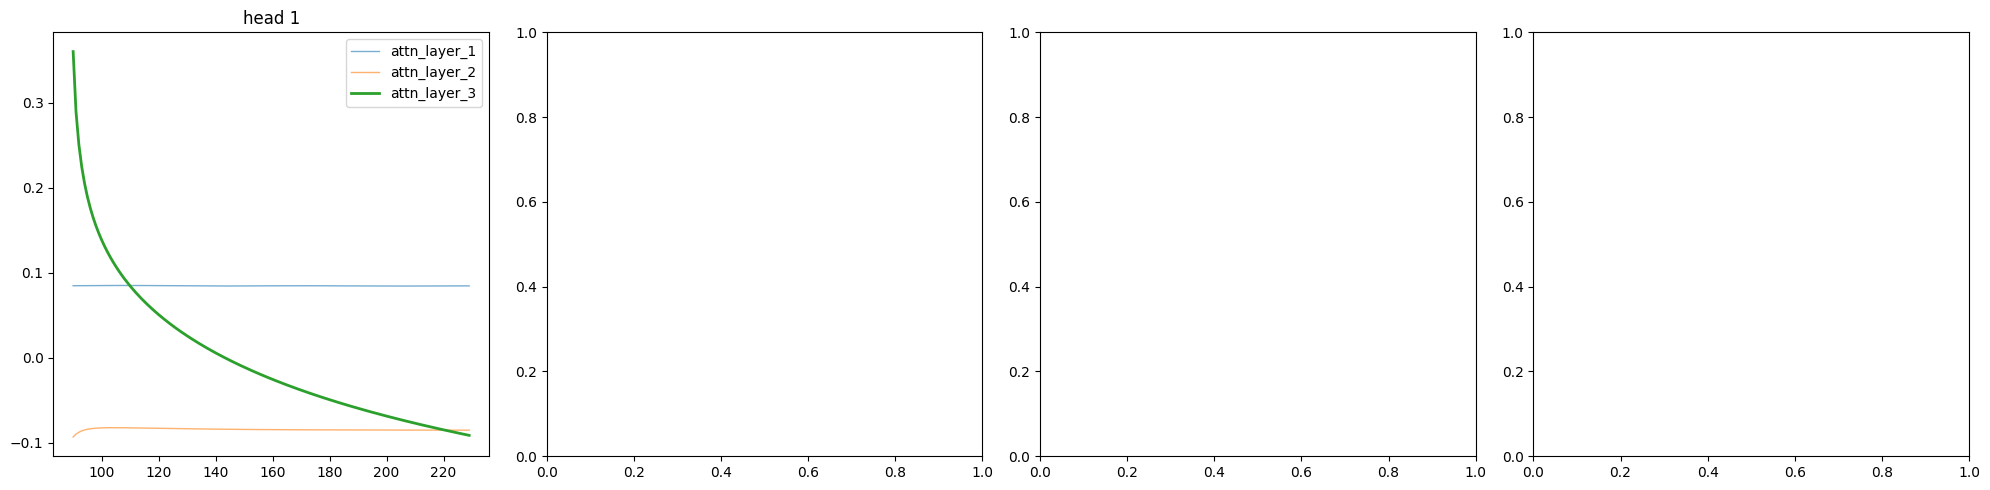

In [118]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

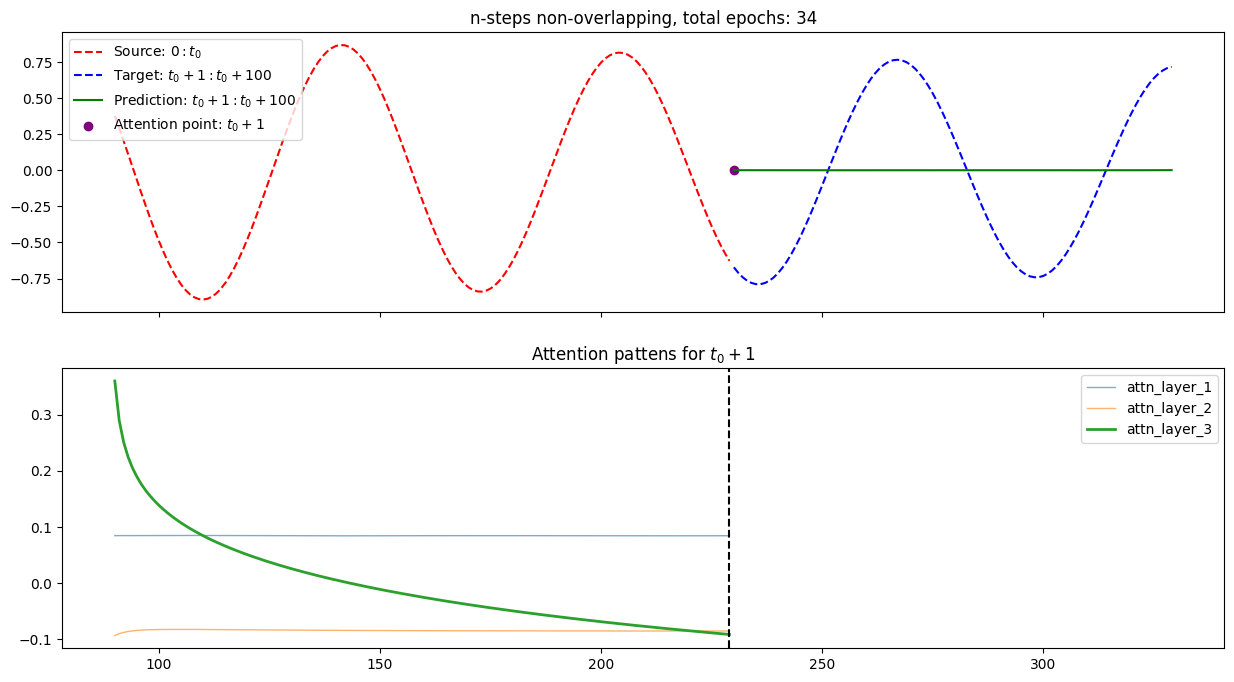

In [119]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Sine function

In [120]:
DATASET_NAME = "sine_multi"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultipleSineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

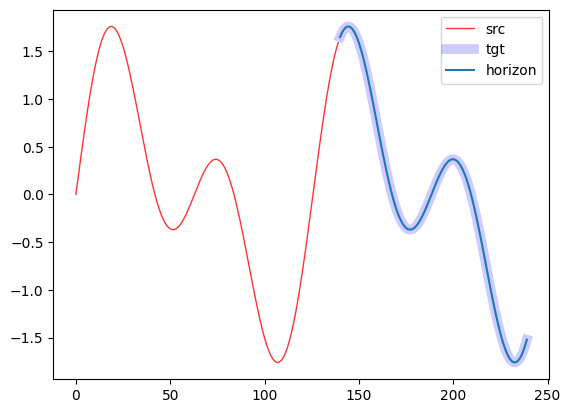

In [121]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [122]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [123]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=1.1133	val_loss=1.0091	train_mape_loss=2.2134	val_mape_loss=1.0808	R_p=['0.9995', '0.9977']
epoch=1	train_loss=1.0141	val_loss=1.0116	train_mape_loss=1.4334	val_mape_loss=1.2418	R_p=['1.0008', '0.9522']
epoch=2	train_loss=1.0100	val_loss=1.0097	train_mape_loss=1.3386	val_mape_loss=1.1055	R_p=['0.9998', '0.9817']
epoch=3	train_loss=1.0081	val_loss=1.0097	train_mape_loss=1.3020	val_mape_loss=1.0715	R_p=['0.9999', '1.0198']
epoch=4	train_loss=1.0070	val_loss=1.0142	train_mape_loss=1.2779	val_mape_loss=1.1770	R_p=['1.0021', '1.0615']
epoch=5	train_loss=1.0064	val_loss=1.0240	train_mape_loss=1.2648	val_mape_loss=1.6078	R_p=['1.0073', '0.8863']
epoch=6	train_loss=1.0057	val_loss=1.0145	train_mape_loss=1.2552	val_mape_loss=1.1506	R_p=['1.0022', '1.0523']
epoch=7	train_loss=1.0054	val_loss=1.0100	train_mape_loss=1.2261	val_mape_loss=1.1254	R_p=['1.0000', '0.9769']
epoch=8	train_loss=1.0042	val_loss=1.0106	train_mape_loss=1.2006	val_mape_loss=1.0379	R_p=['1.0002', '1.0264']
e

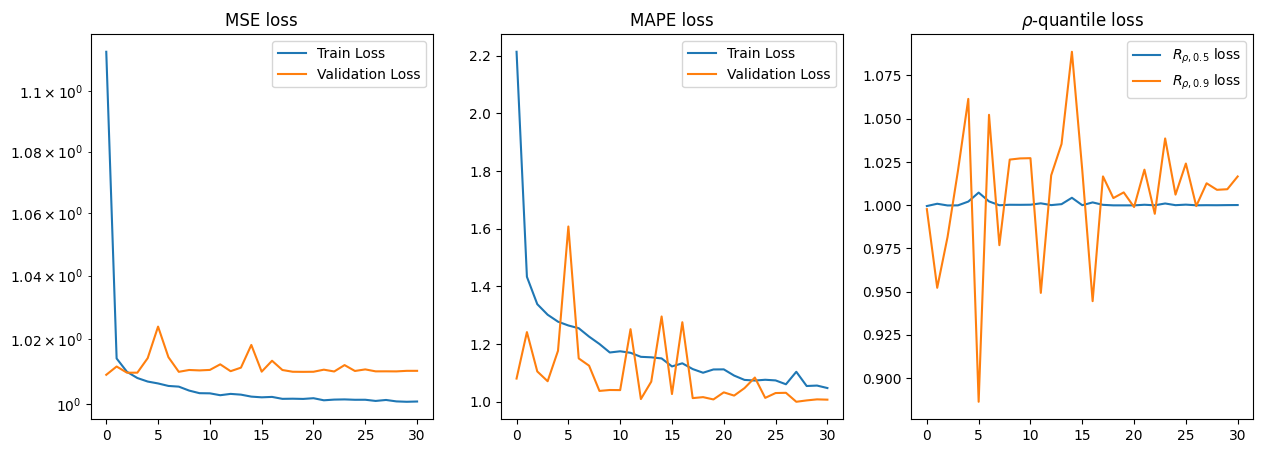

In [124]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [125]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.9986690502166748,
 1.0085240230560302,
 [1.0000137090682983, 1.00018310546875])

In [126]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [127]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.9993891439437866,
 1.0807890043258668,
 tensor([1.0007, 0.9826], device='cuda:0'))

#### Predict

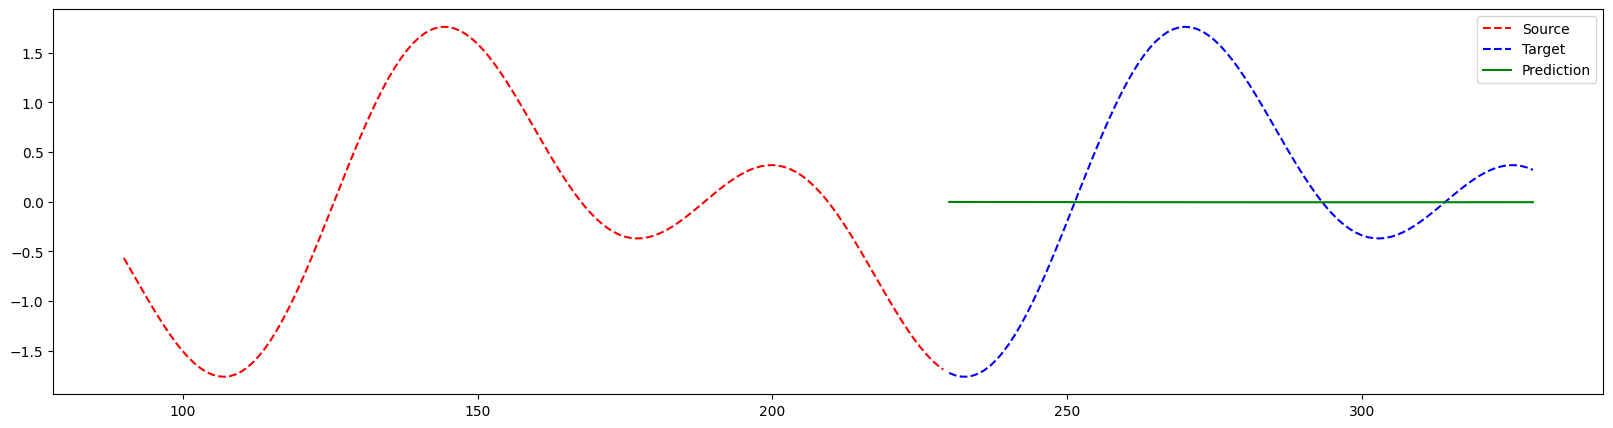

In [128]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [129]:
inspect_step = 0

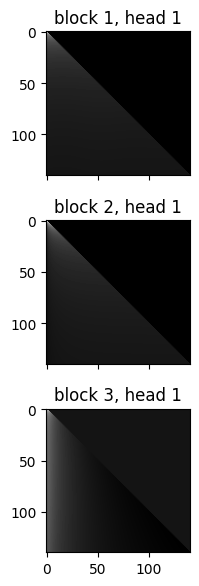

In [130]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

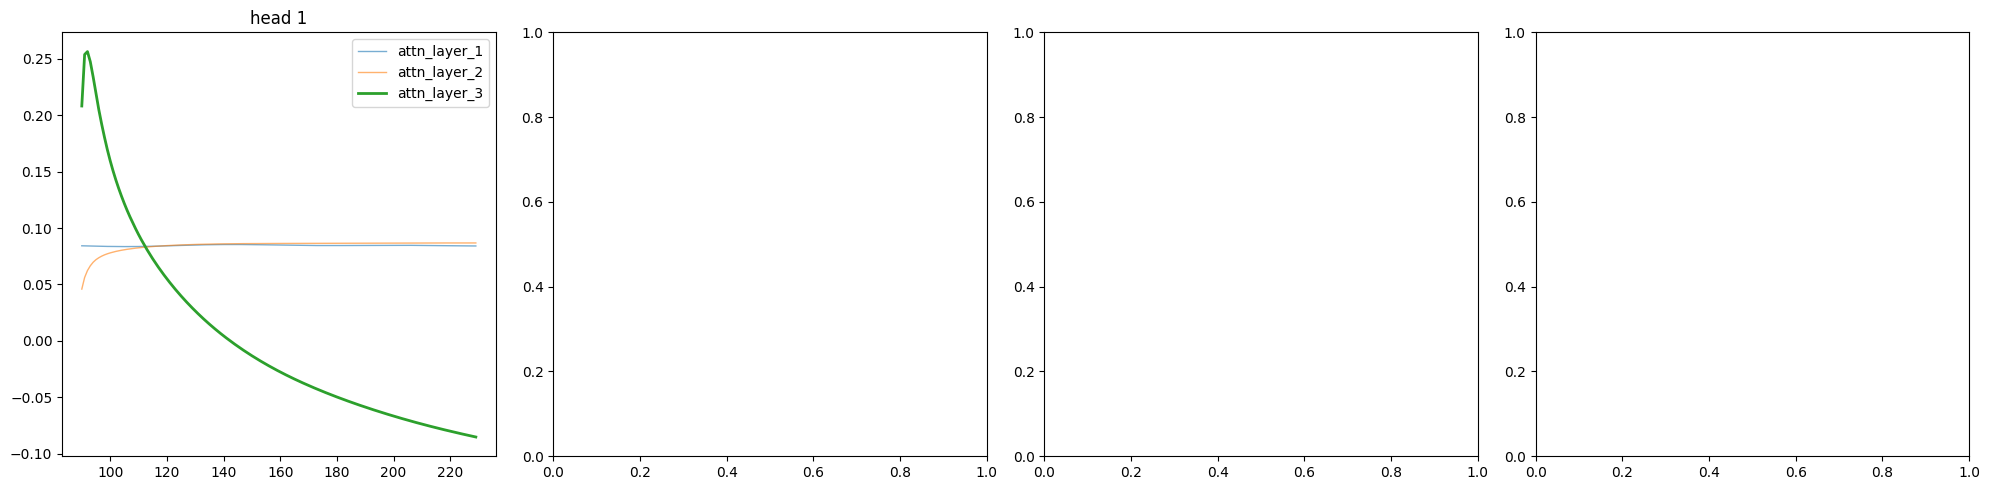

In [131]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

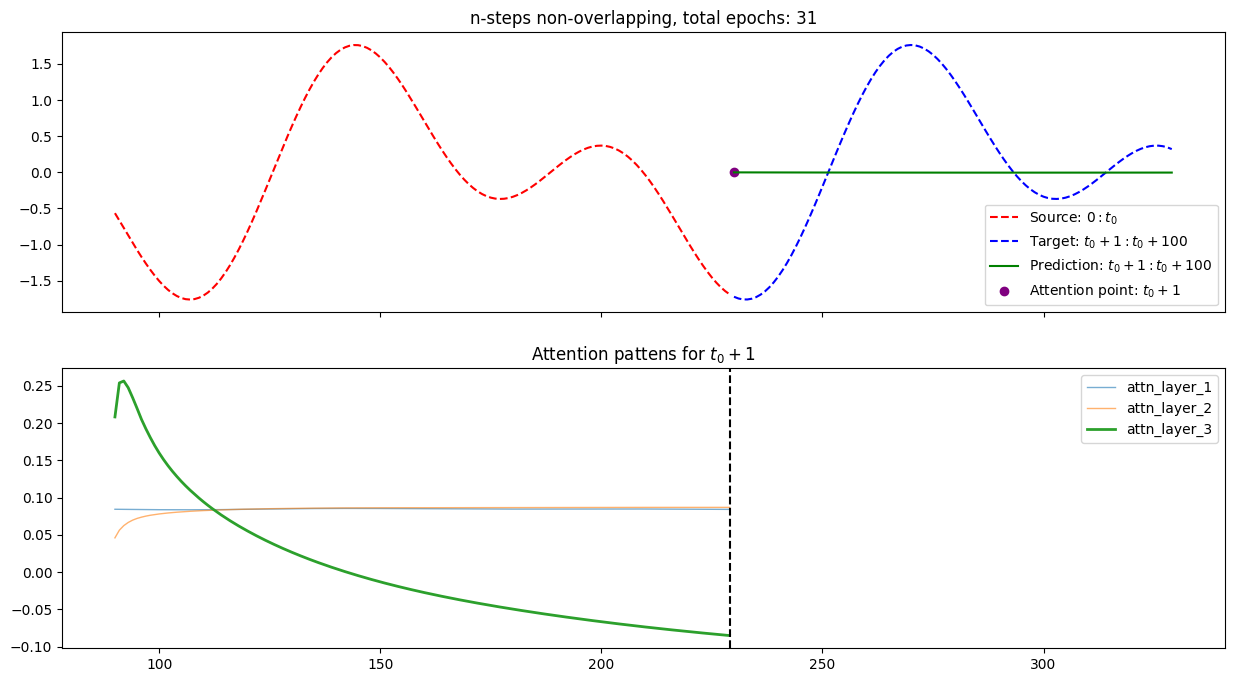

In [132]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 7: $n$-step prediction on `(Decaying/Multi)SawtoothSyntheticDataset` with non-overlapping source and target

### Sawtooth function

In [133]:
DATASET_NAME = "sawtooth"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, p=5, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

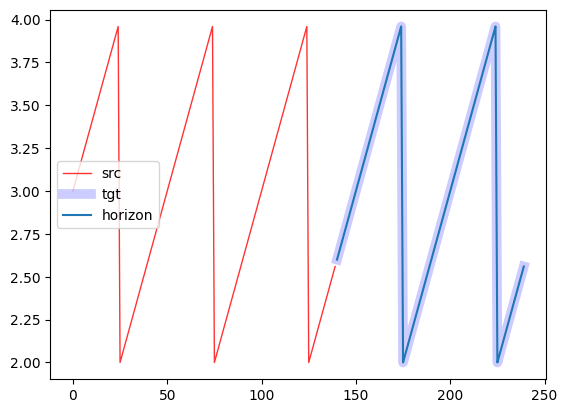

In [134]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [135]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [136]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.6756	val_loss=0.3880	train_mape_loss=0.2172	val_mape_loss=0.2008	R_p=['0.1770', '0.1149']
epoch=1	train_loss=0.3734	val_loss=0.3602	train_mape_loss=0.1843	val_mape_loss=0.1922	R_p=['0.1723', '0.1284']
epoch=2	train_loss=0.3625	val_loss=0.3428	train_mape_loss=0.1826	val_mape_loss=0.1854	R_p=['0.1694', '0.1431']
epoch=3	train_loss=0.3577	val_loss=0.3375	train_mape_loss=0.1817	val_mape_loss=0.1825	R_p=['0.1685', '0.1512']
epoch=4	train_loss=0.3552	val_loss=0.3342	train_mape_loss=0.1814	val_mape_loss=0.1798	R_p=['0.1680', '0.1607']
epoch=5	train_loss=0.3531	val_loss=0.3350	train_mape_loss=0.1810	val_mape_loss=0.1807	R_p=['0.1681', '0.1572']
epoch=6	train_loss=0.3527	val_loss=0.3347	train_mape_loss=0.1810	val_mape_loss=0.1801	R_p=['0.1680', '0.1600']
epoch=7	train_loss=0.3526	val_loss=0.3345	train_mape_loss=0.1810	val_mape_loss=0.1801	R_p=['0.1680', '0.1595']
epoch=8	train_loss=0.3513	val_loss=0.3333	train_mape_loss=0.1807	val_mape_loss=0.1777	R_p=['0.1678', '0.1694']
e

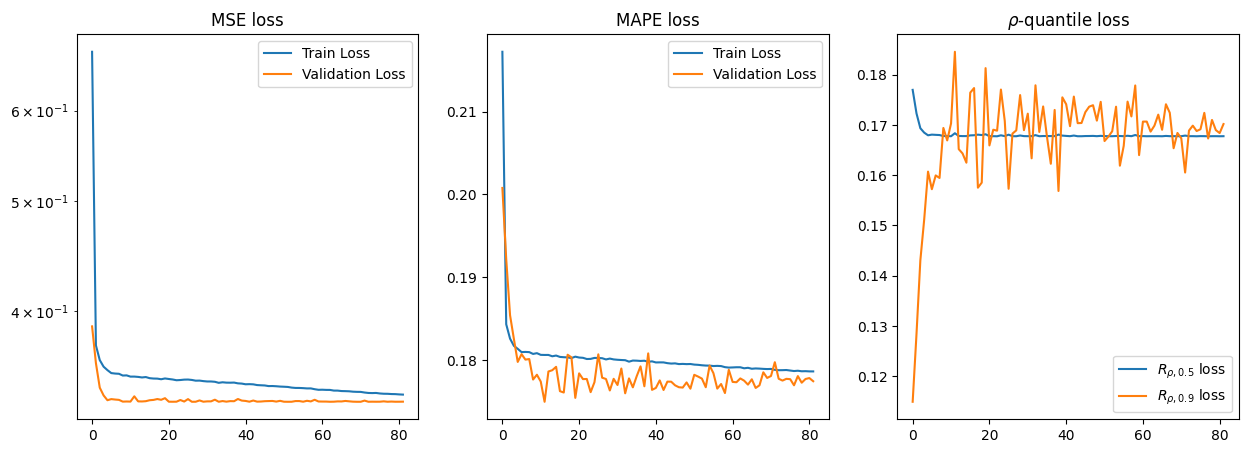

In [137]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [138]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.333314544916153,
 0.17746538627147673,
 [0.16779036819934845, 0.17020781338214874])

In [139]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [140]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.3332159819602966,
 0.17802084708213806,
 tensor([0.1678, 0.1677], device='cuda:0'))

#### Predict

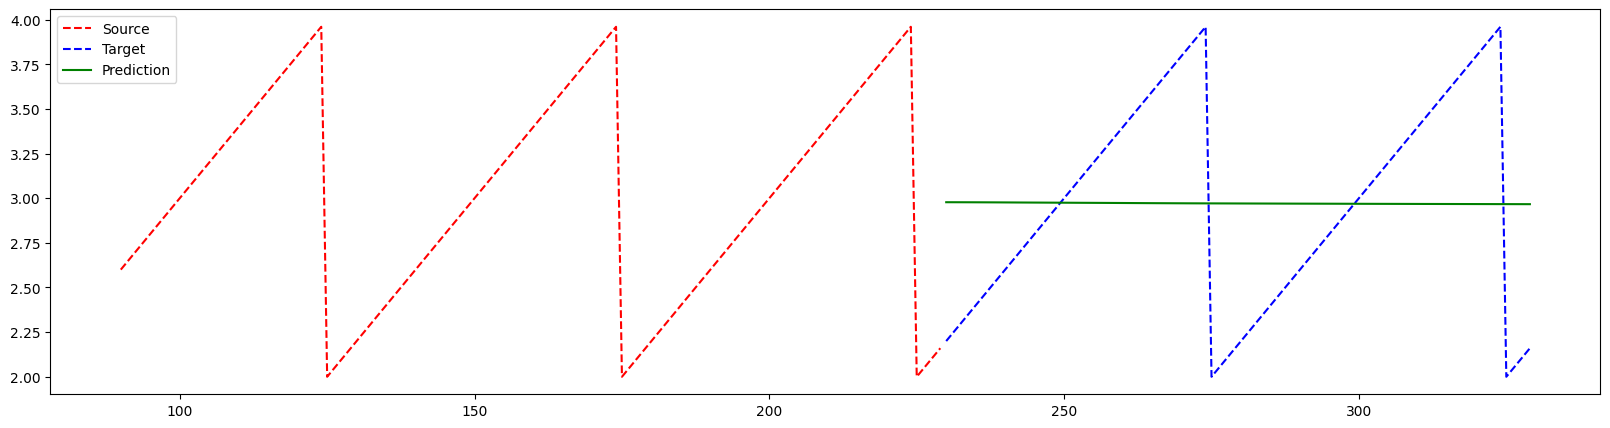

In [141]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [142]:
inspect_step = 0

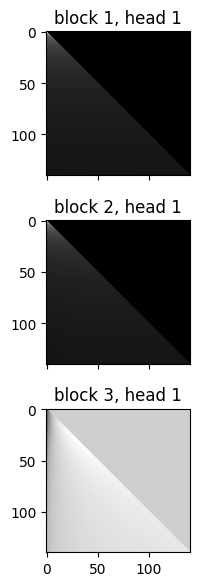

In [143]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

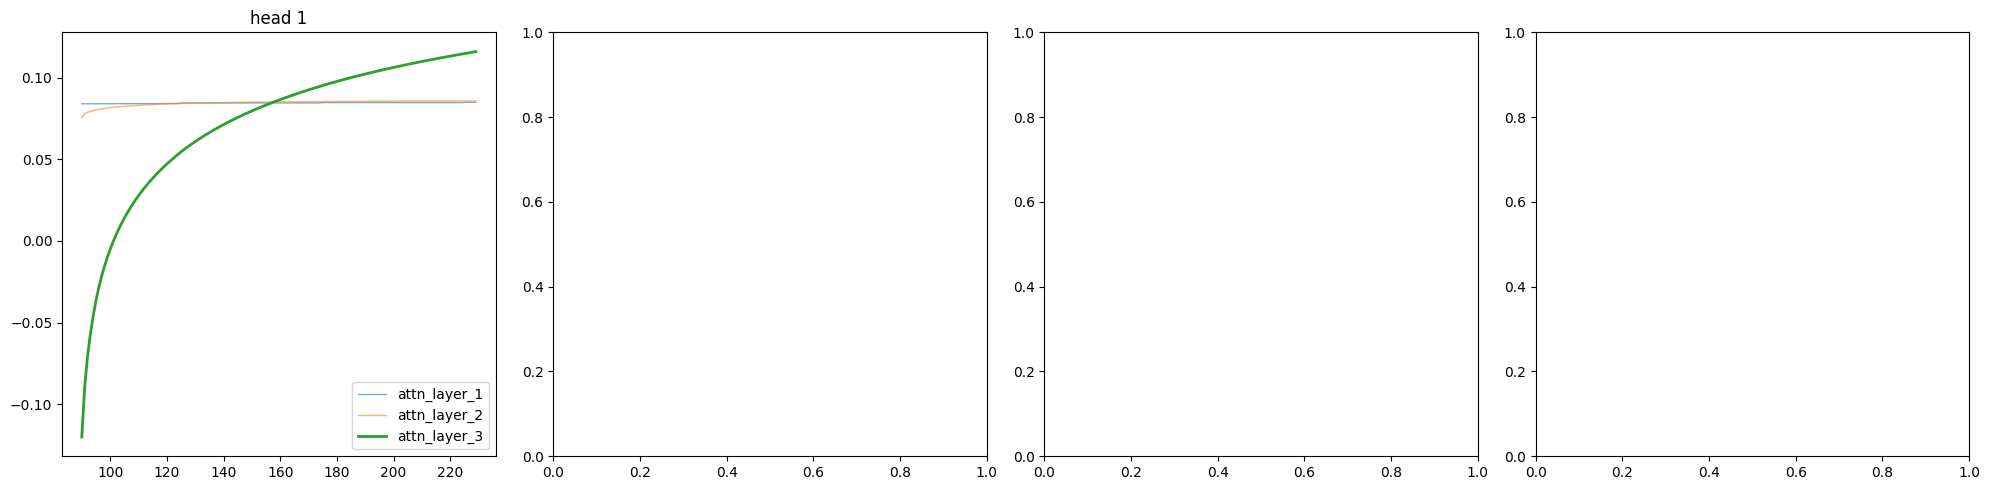

In [144]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

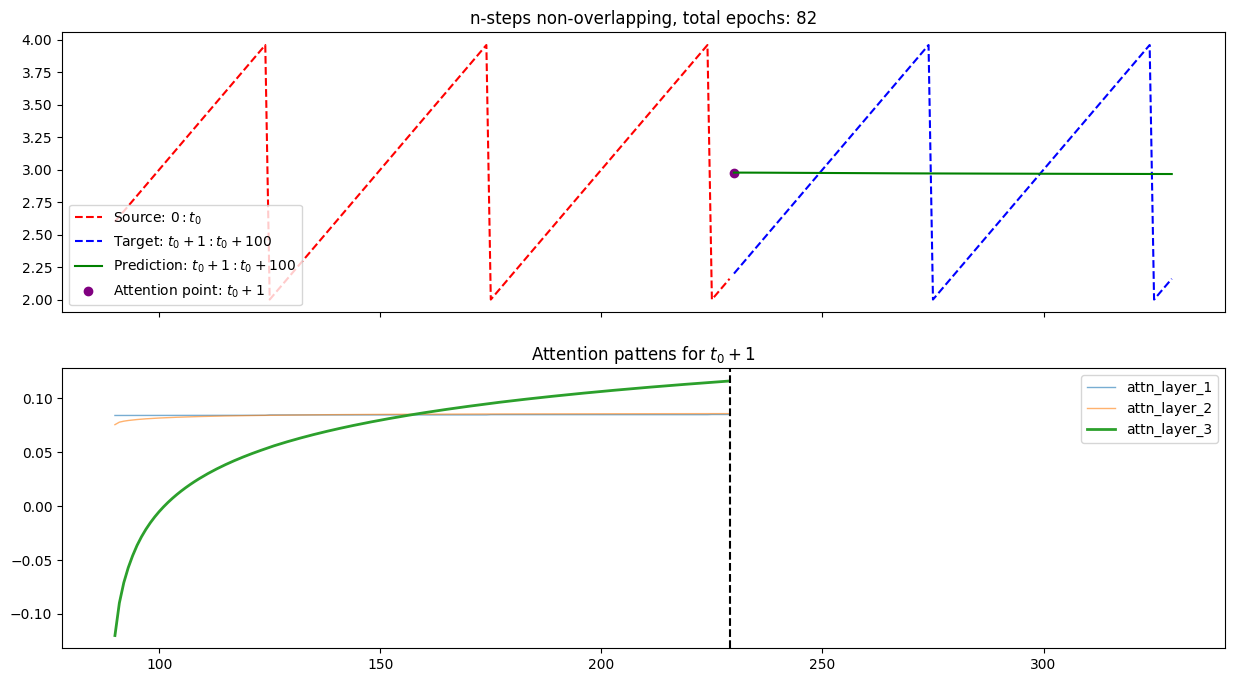

In [145]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Sawtooth function

In [146]:
DATASET_NAME = "sawtooth_decay"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.DecayingSawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, p=5, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

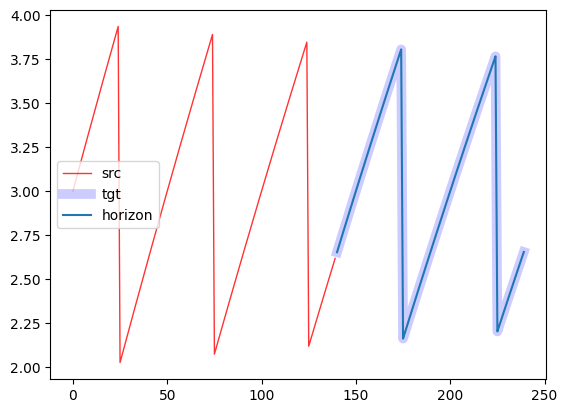

In [147]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [148]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [149]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.2333	val_loss=0.0344	train_mape_loss=0.1060	val_mape_loss=0.0526	R_p=['0.0514', '0.0168']
epoch=1	train_loss=0.0512	val_loss=0.0186	train_mape_loss=0.0581	val_mape_loss=0.0264	R_p=['0.0258', '0.0180']
epoch=2	train_loss=0.0433	val_loss=0.0176	train_mape_loss=0.0528	val_mape_loss=0.0229	R_p=['0.0225', '0.0214']
epoch=3	train_loss=0.0402	val_loss=0.0178	train_mape_loss=0.0505	val_mape_loss=0.0244	R_p=['0.0241', '0.0288']
epoch=4	train_loss=0.0388	val_loss=0.0176	train_mape_loss=0.0494	val_mape_loss=0.0225	R_p=['0.0221', '0.0199']
epoch=5	train_loss=0.0377	val_loss=0.0176	train_mape_loss=0.0486	val_mape_loss=0.0228	R_p=['0.0225', '0.0245']
epoch=6	train_loss=0.0373	val_loss=0.0181	train_mape_loss=0.0482	val_mape_loss=0.0251	R_p=['0.0246', '0.0183']
epoch=7	train_loss=0.0368	val_loss=0.0175	train_mape_loss=0.0479	val_mape_loss=0.0220	R_p=['0.0216', '0.0213']
epoch=8	train_loss=0.0365	val_loss=0.0177	train_mape_loss=0.0476	val_mape_loss=0.0229	R_p=['0.0225', '0.0192']
e

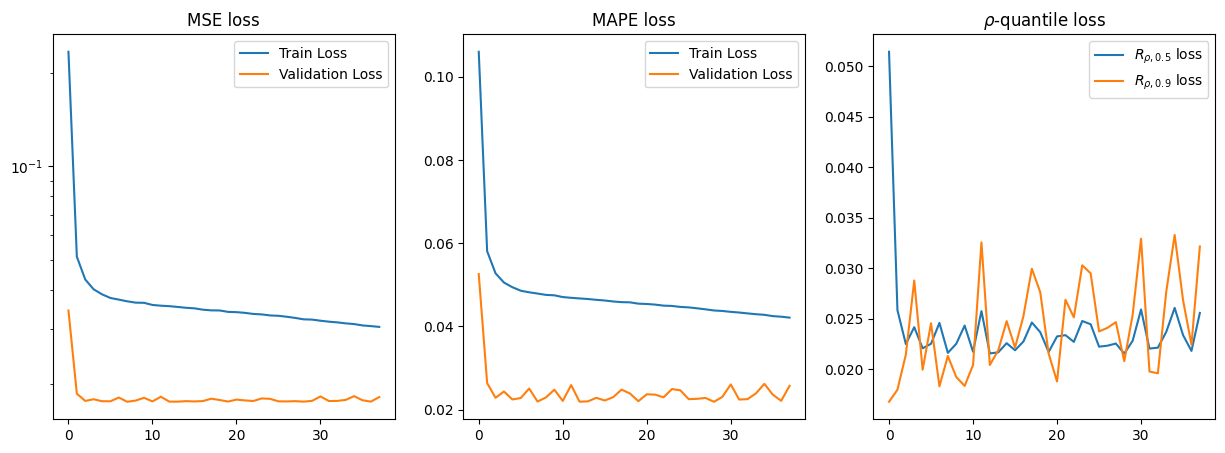

In [150]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [151]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.021334416419267654,
 0.02771050062775612,
 [0.02745930291712284, 0.03399190306663513])

In [152]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [153]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.020741449669003487,
 0.0241454788595438,
 tensor([0.0237, 0.0233], device='cuda:0'))

#### Predict

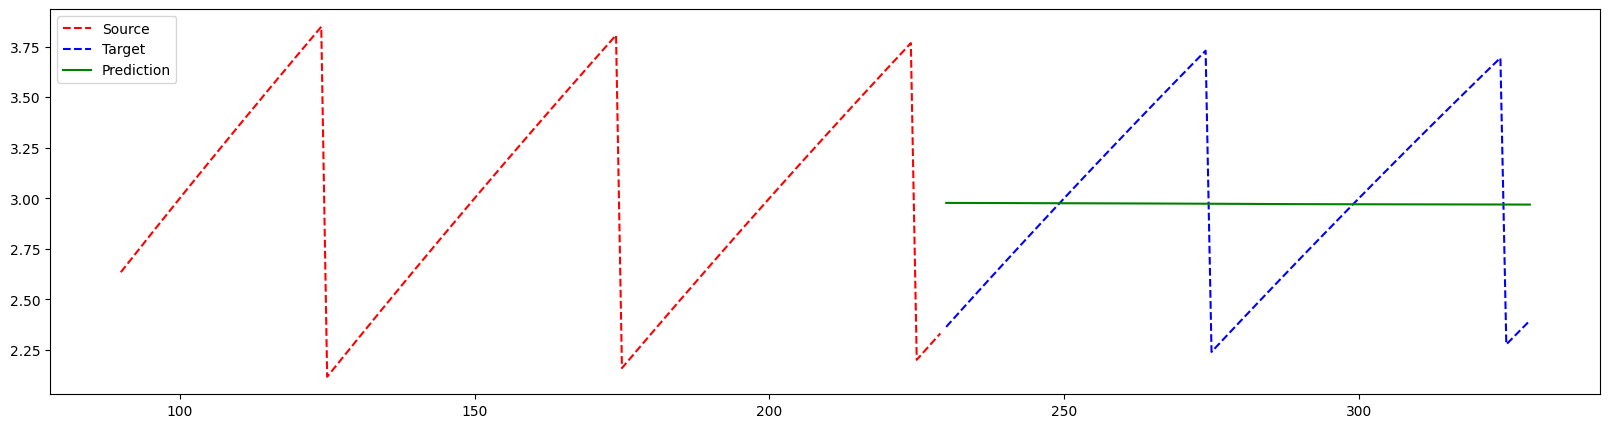

In [154]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [155]:
inspect_step = 0

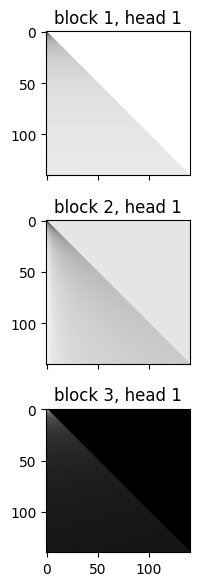

In [156]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

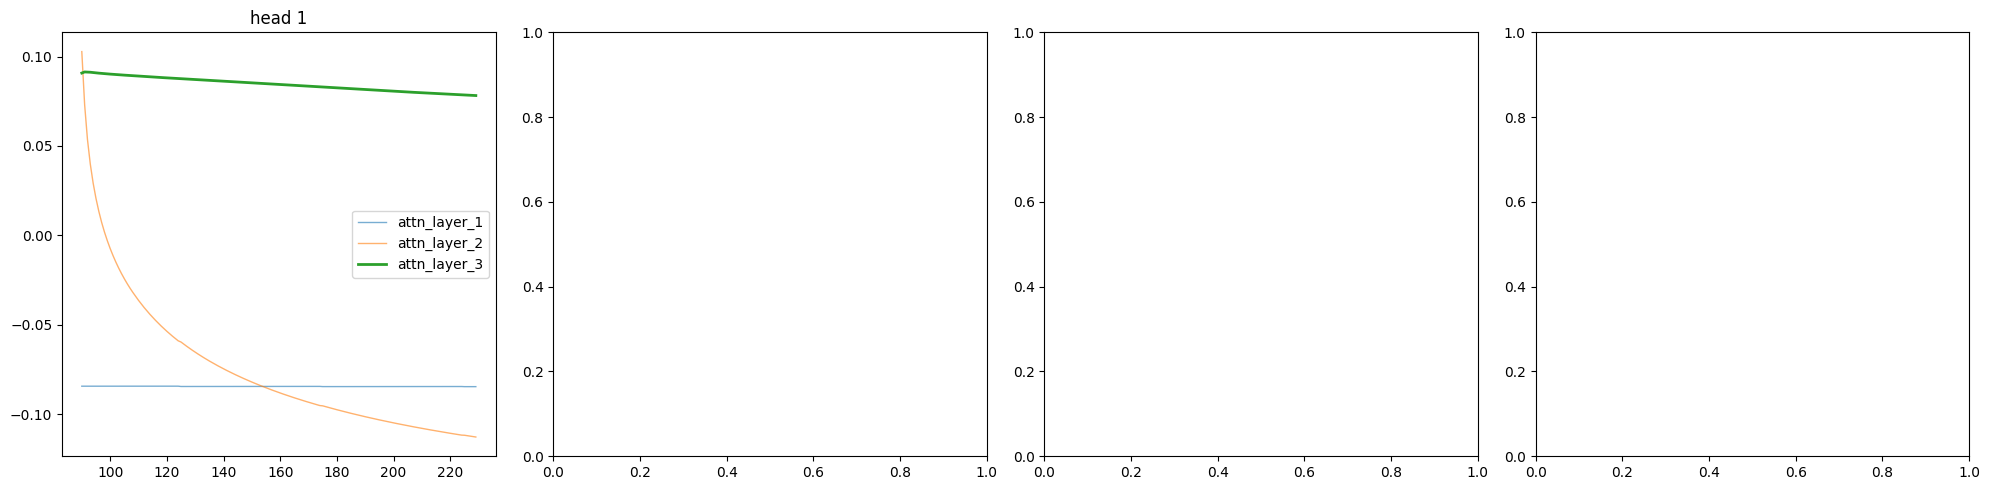

In [157]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

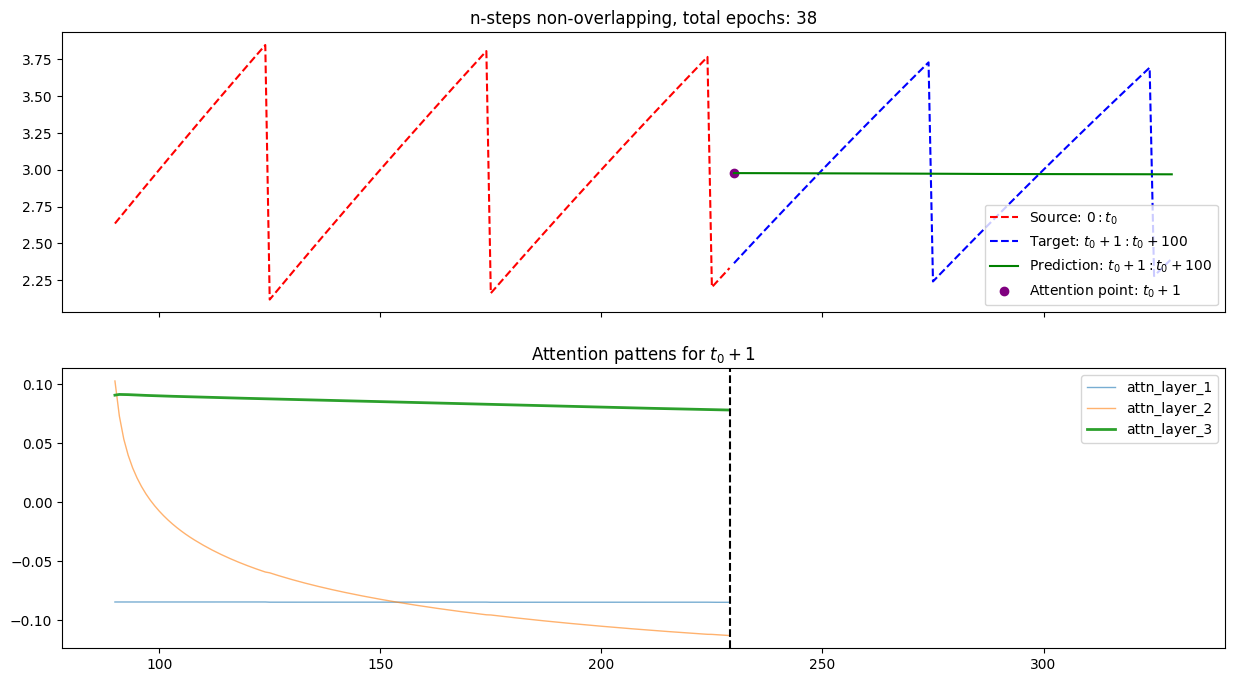

In [158]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Sawtooth function

In [159]:
DATASET_NAME = "sawtooth_multi"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultipleSawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, p=5, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

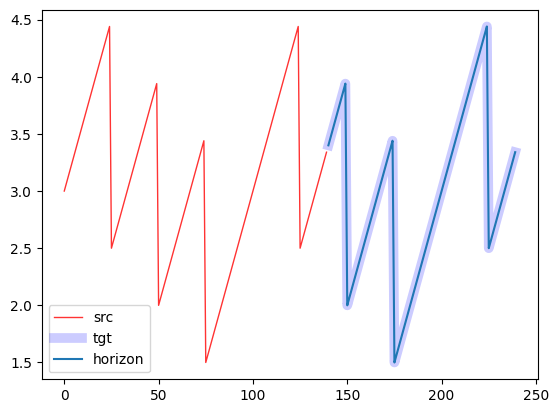

In [160]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [161]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [162]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.7254	val_loss=0.5183	train_mape_loss=0.2497	val_mape_loss=0.2326	R_p=['0.1995', '0.1631']
epoch=1	train_loss=0.5351	val_loss=0.5034	train_mape_loss=0.2249	val_mape_loss=0.2245	R_p=['0.1970', '0.1811']
epoch=2	train_loss=0.5269	val_loss=0.5010	train_mape_loss=0.2237	val_mape_loss=0.2223	R_p=['0.1966', '0.1872']
epoch=3	train_loss=0.5235	val_loss=0.4998	train_mape_loss=0.2230	val_mape_loss=0.2197	R_p=['0.1964', '0.1956']
epoch=4	train_loss=0.5219	val_loss=0.5000	train_mape_loss=0.2227	val_mape_loss=0.2191	R_p=['0.1964', '0.1979']
epoch=5	train_loss=0.5212	val_loss=0.4997	train_mape_loss=0.2227	val_mape_loss=0.2190	R_p=['0.1964', '0.1982']
epoch=6	train_loss=0.5203	val_loss=0.4998	train_mape_loss=0.2225	val_mape_loss=0.2201	R_p=['0.1964', '0.1942']
epoch=7	train_loss=0.5202	val_loss=0.5000	train_mape_loss=0.2226	val_mape_loss=0.2206	R_p=['0.1964', '0.1926']
epoch=8	train_loss=0.5193	val_loss=0.5005	train_mape_loss=0.2224	val_mape_loss=0.2175	R_p=['0.1965', '0.2042']
e

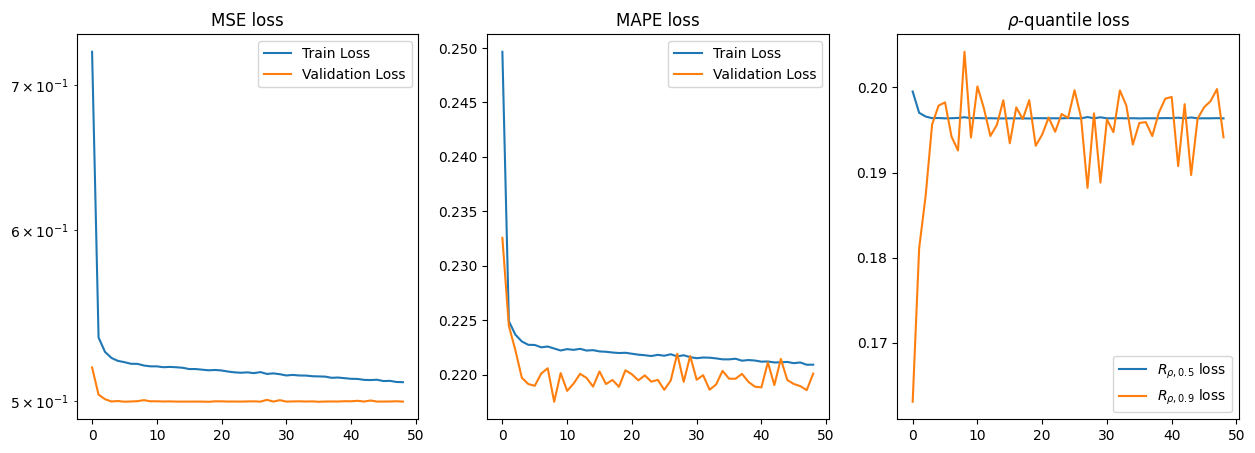

In [163]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [164]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.49977242517471315,
 0.22009003663063048,
 [0.19636400043964386, 0.19414889812469482])

In [165]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [166]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.499777482509613,
 0.21889165961742402,
 tensor([0.1964, 0.1985], device='cuda:0'))

#### Predict

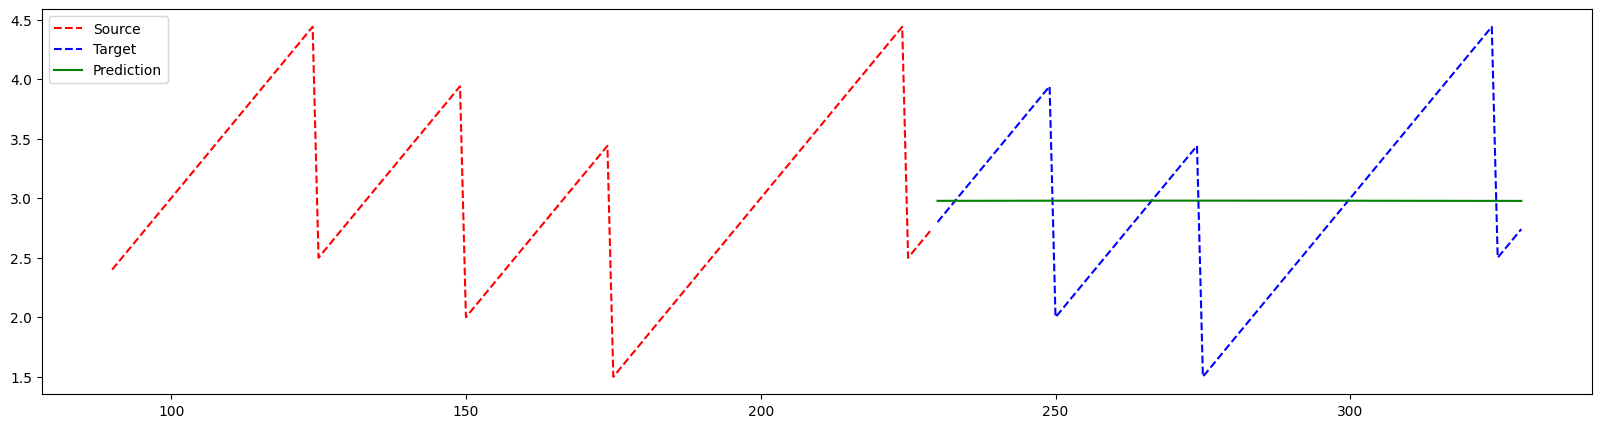

In [167]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [168]:
inspect_step = 0

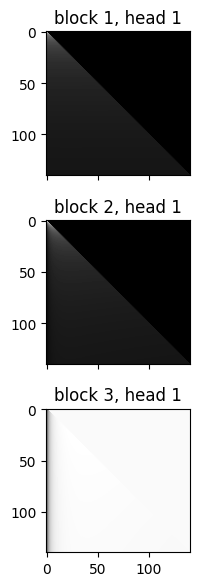

In [169]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

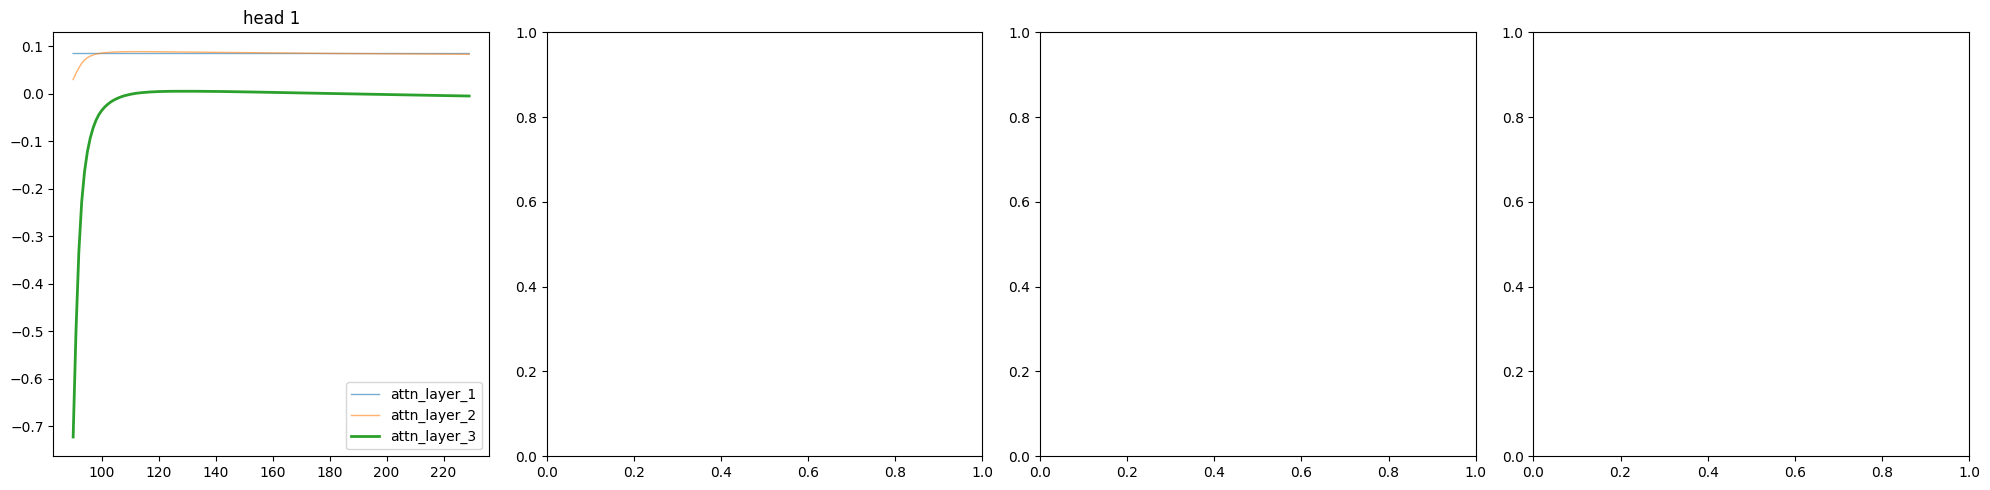

In [170]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

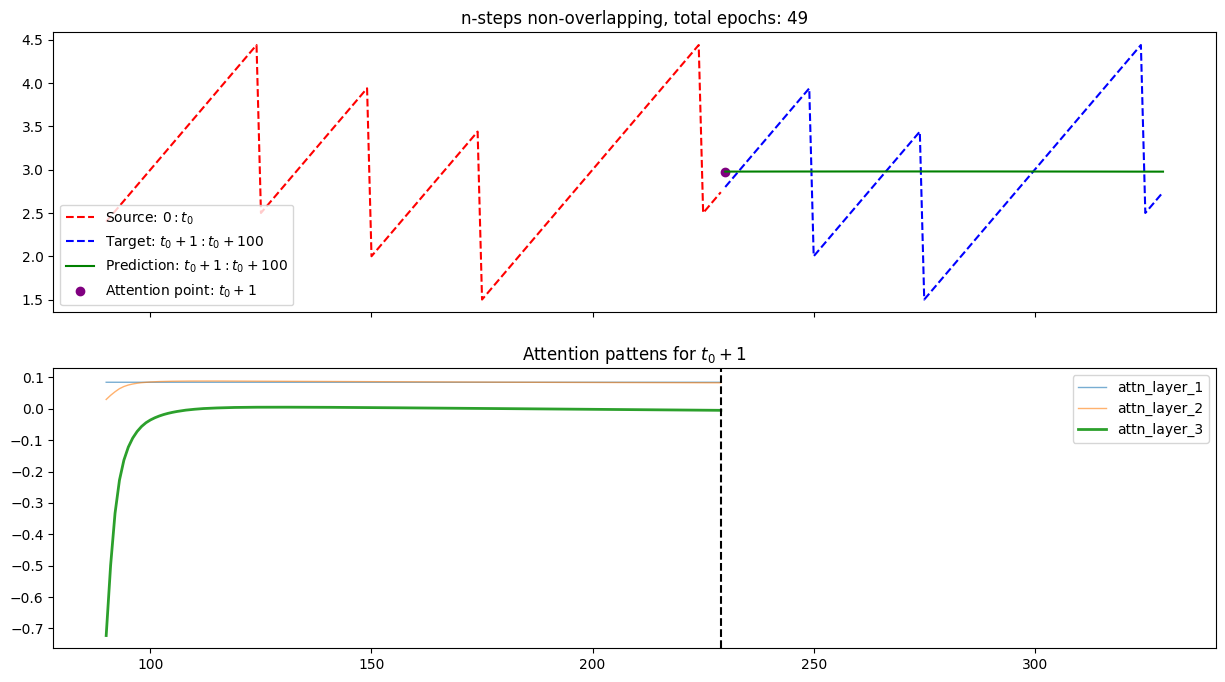

In [171]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)